In [ ]:
import os
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Set parameters
start_scope()
prefs.codegen.target = 'numpy'

# Time parameters
dt = 0.1*ms
defaultclock.dt = dt

# Neuron parameters
sigma_noise_exc_tha = 1
sigma_noise_inh_tha = 1
sigma_noise_exc = 1  # Excitatory neuron noise intensity
sigma_noise_inh = 1  # Inhibitory neuron noise intensity
sigma_noise_L23_exc = 1  # L23 excitatory neuron noise intensity
sigma_noise_L23_inh = 1  # L23 inhibitory neuron noise intensity
sigma_noise_L4_exc = 1   # L4 excitatory neuron noise intensity
sigma_noise_L4_inh = 1   # L4 inhibitory neuron noise intensity
sigma_noise_L5_exc = 1   # L5 excitatory neuron noise intensity
sigma_noise_L5_inh = 1   # L5 inhibitory neuron noise intensity
sigma_noise_L6_exc = 0.3   # L6 excitatory neuron noise intensity
sigma_noise_L6_inh = 0.3   # L6 inhibitory neuron noise intensity
v_rest = -65        # Dimensionless voltage value (represents -65mV)
tau_syn_exc = 5*ms  # Excitatory synaptic time constant
tau_syn_inh = 10*ms  # Inhibitory synaptic time constant
tau_noise = 15*ms   # Noise time constant
tau_afferent = 10*ms  # Afferent excitation time constant (new)

# Delay parameters
delay_rc = 15*ms    # Delay from relay to cortex
delay_cr = 15*ms    # Delay from cortex to relay
delay_cortical = 3*ms  # Intracortical delay

def make_layer(N_e, N_i, name, inh_type='PV', 
               sigma_noise_exc_layer=0.2, sigma_noise_inh_layer=0.2):
    # Excitatory neuron parameters (regular spiking)
    a_exc = 0.02
    b_exc = 0.2
    c_exc = -65
    d_exc = 2
    
    # Inhibitory neuron parameters (differentiated by layer as PV or SOM type)
    if inh_type == 'PV':  # Fast spiking (L4, L6)
        a_inh = 0.1
        b_inh = 0.2
        c_inh = -65
        d_inh = 2.0
    elif inh_type == 'SOM':  # Slower spiking (L2/3, L5)
        a_inh = 0.1
        b_inh = 0.2
        c_inh = -65
        d_inh = 2.0
    
    # Base equations - Using current noise (added potassium leak conductance)
    base_eqs = '''
    dv/dt = (0.04*v**2 + 5*v + 140 - u + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
    du/dt = a*(b*v - u)/ms : 1
    dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
    dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
    dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
    g_KL : 1 (constant)  # Potassium leak conductance
    E_KL : 1 (constant)
    a : 1 (constant)
    b : 1 (constant)
    c : 1 (constant)
    d : 1
    tau_noise : second (constant)
    sigma_noise : 1 (constant)
    tau_exc : second (constant)  # Excitatory synaptic time constant
    tau_inh : second (constant)  # Inhibitory synaptic time constant
    '''
    
    # Create neuron groups
    exc = NeuronGroup(N_e, base_eqs, threshold='v>=30', reset='v=c; u+=d', 
                     method='euler', name=f'exc_{name}')
    inh = NeuronGroup(N_i, base_eqs, threshold='v>=30', reset='v=c; u+=d', 
                     method='euler', name=f'inh_{name}')
    
    # Set parameters
    exc.v = c_exc
    exc.u = b_exc * c_exc
    exc.a = a_exc
    exc.b = b_exc
    exc.c = c_exc
    exc.d = d_exc
    exc.sigma_noise = sigma_noise_exc_tha
    exc.tau_noise = tau_noise
    exc.tau_exc = tau_syn_exc
    exc.tau_inh = tau_syn_inh
    exc.g_KL = 0.001
    exc.E_KL = -80
    
    inh.v = c_inh
    inh.u = b_inh * c_inh
    inh.a = a_inh
    inh.b = b_inh
    inh.c = c_inh
    inh.d = d_inh
    inh.sigma_noise = sigma_noise_exc_tha
    inh.tau_noise = tau_noise
    inh.tau_exc = tau_syn_exc
    inh.tau_inh = tau_syn_inh
    inh.g_KL = 0.001  # Default potassium leak conductance
    inh.E_KL = -80
    
    print(f"Created {name} with {N_e} exc and {N_i} inh neurons (inh_type={inh_type}), "
          f"exc noise={sigma_noise_exc_layer}, inh noise={sigma_noise_inh_layer}")
    return exc, inh

# Create cortical layer neurons
L23_exc, L23_inh = make_layer(80, 20, "L23", inh_type='SOM', 
                             sigma_noise_exc_layer=sigma_noise_L23_exc, 
                             sigma_noise_inh_layer=sigma_noise_L23_inh)

L4_exc, L4_inh = make_layer(80, 20, "L4", inh_type='PV', 
                           sigma_noise_exc_layer=sigma_noise_L4_exc, 
                           sigma_noise_inh_layer=sigma_noise_L4_inh)

L5_exc, L5_inh = make_layer(80, 20, "L5", inh_type='SOM', 
                           sigma_noise_exc_layer=sigma_noise_L5_exc, 
                           sigma_noise_inh_layer=sigma_noise_L5_inh)

L6_exc, L6_inh = make_layer(80, 20, "L6", inh_type='PV', 
                           sigma_noise_exc_layer=sigma_noise_L6_exc, 
                           sigma_noise_inh_layer=sigma_noise_L6_inh)

# Create relay neurons (thalamic neurons)
N_relay = 100
gT = 0.1
eCa = 120
tau_m_T_Ca = 5*ms
tau_h_T_Ca = 15*ms

# Modified relay neuron equations - Added afferent excitation term
relay_eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u - I_T_Ca + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
du/dt = a*(b*v - u)/ms : 1
dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
dm_T_Ca/dt = (m_inf_T_Ca - m_T_Ca)/tau_m_T_Ca : 1
dh_T_Ca/dt = (h_inf_T_Ca - h_T_Ca)/tau_h_T_Ca : 1
m_inf_T_Ca = 1/(1+exp(-(v+50)/7)) : 1
h_inf_T_Ca = 1/(1+exp((v+70)/5.5)) : 1
I_T_Ca = gT * m_T_Ca**3 * h_T_Ca * (v - eCa) : 1
g_KL : 1 (constant)  # Potassium leak conductance
E_KL : 1 (constant)  # Potassium reversal potential
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1
tau_noise : second (constant)
sigma_noise : 1 (constant)
gT : 1 (constant)
tau_m_T_Ca : second (constant)
tau_h_T_Ca : second (constant)
tau_exc : second (constant)  # Excitatory synaptic time constant
tau_inh : second (constant)  # Inhibitory synaptic time constant
'''

relay = NeuronGroup(N_relay, relay_eqs, threshold='v>=30', reset='v=c; u+=d', 
                   method='euler', name='relay')

# Set relay neuron parameters
a_relay = 0.03
b_relay = 0.25
c_relay = -52
d_relay = 0
relay.E_KL = -80
relay.v = c_relay
relay.u = b_relay * c_relay
relay.a = a_relay
relay.b = b_relay
relay.c = c_relay
relay.d = d_relay
relay.sigma_noise = sigma_noise_exc_tha
relay.tau_noise = tau_noise
relay.gT = gT
relay.tau_m_T_Ca = tau_m_T_Ca
relay.tau_h_T_Ca = tau_h_T_Ca
relay.g_KL = 0.001  # Default potassium leak conductance
relay.tau_exc = tau_syn_exc
relay.tau_inh = tau_syn_inh

# Create nRt neurons (thalamic reticular nucleus)
N_nrt = 100
gT_nrt = 0.1  # Modified: Added T-type calcium channels, weaker conductance
tau_h_T_Ca_nrt = 15*ms

# Modified nrt neuron equations - Added afferent excitation term
nrt_eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u - I_T_Ca + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
du/dt = a*(b*v - u)/ms : 1
dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
dm_T_Ca/dt = (m_inf_T_Ca - m_T_Ca)/tau_m_T_Ca : 1
dh_T_Ca/dt = (h_inf_T_Ca - h_T_Ca)/tau_h_T_Ca : 1
m_inf_T_Ca = 1/(1+exp(-(v+50)/7)) : 1
h_inf_T_Ca = 1/(1+exp((v+70)/5.5)) : 1
I_T_Ca = gT * m_T_Ca**3 * h_T_Ca * (v - eCa) : 1
g_KL : 1 (constant)  # Potassium leak conductance
E_KL : 1 (constant)  # Potassium reversal potential
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1
tau_syn : second (constant)
gT : 1 (constant)
tau_m_T_Ca : second (constant)
tau_h_T_Ca : second (constant)
eCa : 1 (constant)
tau_noise : second (constant)
sigma_noise : 1 (constant)
tau_exc : second (constant)  # Excitatory synaptic time constant
tau_inh : second (constant)  # Inhibitory synaptic time constant
'''

nrt = NeuronGroup(N_nrt, nrt_eqs, threshold='v>=30', reset='v=c; u+=d', 
                 method='euler', name='nrt')

# Set nRt neuron parameters tonic spiking
a_nrt = 0.02
b_nrt = 0.25
c_nrt = -65
d_nrt = 2
nrt.v = c_nrt
nrt.u = b_nrt * c_nrt
nrt.a = a_nrt
nrt.b = b_nrt
nrt.c = c_nrt
nrt.d = d_nrt
nrt.gT = gT_nrt
nrt.tau_m_T_Ca = tau_m_T_Ca
nrt.tau_h_T_Ca = tau_h_T_Ca_nrt
nrt.eCa = eCa
nrt.sigma_noise = sigma_noise_inh_tha
nrt.tau_noise = tau_noise
nrt.g_KL = 0.006  # Default potassium leak conductance
nrt.E_KL = -70
nrt.tau_exc = tau_syn_exc
nrt.tau_inh = tau_syn_inh

# Create thalamic local inhibitory neurons
N_local_inh = 100
# Modified local inhibitory neuron equations - Added afferent excitation term
local_inh_eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
du/dt = a*(b*v - u)/ms : 1
dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
g_KL : 1 (constant)  # Potassium leak conductance
E_KL : 1 (constant)  # Potassium reversal potential
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1
tau_exc : second (constant)  # Excitatory synaptic time constant
tau_inh : second (constant)  # Inhibitory synaptic time constant
tau_noise : second (constant)
sigma_noise : 1 (constant)
'''

local_inh = NeuronGroup(N_local_inh, local_inh_eqs, threshold='v>=30', 
                      reset='v=c; u+=d', method='euler', name='local_inh')

# Set local inhibitory neuron parameters
a_local = 0.1
b_local = 0.2
c_local = -65
d_local = 2.0
local_inh.v = c_local
local_inh.u = b_local * c_local
local_inh.a = a_local
local_inh.b = b_local
local_inh.c = c_local
local_inh.d = d_local
local_inh.sigma_noise = sigma_noise_inh_tha
local_inh.tau_noise = tau_noise
local_inh.g_KL = 0.006  # Default potassium leak conductance
local_inh.tau_exc = tau_syn_exc
local_inh.tau_inh = tau_syn_inh
local_inh.E_KL = -80 # <<< 建議新增這一行

# Create Prethalamic neurons
prethalamic_eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
du/dt = a*(b*v - u)/ms : 1
dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
g_KL : 1 (constant)  # Potassium leak conductance
E_KL : 1 (constant)  # Potassium reversal potential
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1
tau_exc : second (constant)  # Excitatory synaptic time constant
tau_inh : second (constant)  # Inhibitory synaptic time constant
tau_noise : second (constant)
sigma_noise : 1 (constant)
'''

N_prethalamic = 100
prethalamic = NeuronGroup(N_prethalamic, prethalamic_eqs, threshold='v>=30', 
                         reset='v=c; u+=d', method='euler', name='prethalamic')

# Set Prethalamic neuron parameters
a_pre = 0.02
b_pre = 0.2
c_pre = -65
d_pre = 6
prethalamic.v = c_pre
prethalamic.u = b_pre * c_pre
prethalamic.a = a_pre
prethalamic.b = b_pre
prethalamic.c = c_pre
prethalamic.d = d_pre
prethalamic.sigma_noise = sigma_noise_exc
prethalamic.tau_noise = tau_noise
prethalamic.g_KL = 0.006  # Default potassium leak conductance
prethalamic.E_KL = -80
prethalamic.tau_exc = tau_syn_exc
prethalamic.tau_inh = tau_syn_inh

# Set time constants after creating neuron groups
# For cortical neurons
for layer in [L23_exc, L23_inh, L4_exc, L4_inh, L5_exc, L5_inh, L6_exc, L6_inh]:
    layer.tau_exc = tau_syn_exc
    layer.tau_inh = tau_syn_inh

# Sleep stage setup function
# === Create 100Hz background input ===
print("\nCreating 100Hz background input...")

# Create independent 100Hz Poisson input for each thalamic neuron
background_relay = PoissonGroup(N_relay, rates=100*Hz, name='background_relay')
background_nrt = PoissonGroup(N_nrt, rates=100*Hz, name='background_nrt')
background_local_inh = PoissonGroup(N_local_inh, rates=100*Hz, name='background_local_inh')

# Create background input connections
bg2relay = Synapses(background_relay, relay, 
                   model='w:1', 
                   on_pre='I_exc_post += w',
                   delay=0*ms, 
                   name='bg2relay')
# Add connections
bg2relay.connect()

bg2nrt = Synapses(background_nrt, nrt, 
                 model='w:1', 
                 on_pre='I_exc_post += w',
                 delay=0*ms, 
                 name='bg2nrt')
# Add connections
bg2nrt.connect()

bg2local_inh = Synapses(background_local_inh, local_inh, 
                       model='w:1', 
                       on_pre='I_exc_post += w',
                       delay=0*ms, 
                       name='bg2local_inh')
# Add connections
bg2local_inh.connect()

# Set initial weights
bg2relay.w = 0.0
bg2nrt.w = 0.0
bg2local_inh.w = 0.0

# Sleep stage setup function - Modified to use g_input for background input strength
def set_sleep_stage(stage):
    """Set parameters for different sleep stages (based on Li et al. 2017)"""
    # List of all neuron groups
    all_neuron_groups = [prethalamic, relay, nrt, local_inh, 
                        L23_exc, L23_inh, L4_exc, L4_inh,
                        L5_exc, L5_inh, L6_exc, L6_inh]
    
    if stage == "wake_eyes_closed":  # α oscillations
        # Thalamic parameters (Table 1)
        relay.g_KL = 0.00      # TC cells completely block potassium leak current
        nrt.g_KL = 0.01      # RE cells reduce potassium leak conductance
        local_inh.g_KL = 0.02  # IN cells increase potassium leak conductance
        relay.a = 0.02
        relay.b = 0.4
        relay.c = -65 
        relay.d = 2
        
        # Set background input strength (g_input)
        bg2relay.w = 0.4     # TC cells medium input strength
        bg2nrt.w = 0.2      # RE cells medium input strength
        bg2local_inh.w = 0.02 # IN cells medium input strength
        
    elif stage == "wake_eyes_open":  # γ oscillations
        # Thalamic parameters (Table 1)
        relay.g_KL = 0.0
        nrt.g_KL = 0.0
        local_inh.g_KL = 0.0
        relay.a = 0.02
        relay.b = 0.2
        relay.c = -65
        relay.d = 6.0
        L4_inh.tau_inh = 5*ms
        L23_inh.tau_inh = 5*ms
        L5_inh.tau_inh = 5*ms
        L6_inh.tau_inh = 5*ms
        
        L4_inh.g_KL = 0.0
        L23_inh.g_KL = 0.0
        L5_inh.g_KL = 0.0
        L6_inh.g_KL = 0.0
        L4_exc.g_KL = 0.0
        L23_exc.g_KL = 0.0
        L5_exc.g_KL = 0.0
        L6_exc.g_KL = 0.0

        
        # Set background input strength (g_input)
        bg2relay.w = 0.5     # TC cells strong input strength 0.7
        bg2nrt.w = 0.2      # RE cells medium input strength 0.02
        bg2local_inh.w = 0.05 # IN cells medium input strength 0.01

        relay.gT = 0
        nrt.gT = 0
        nrt2relay.w = 0.1

        # Weaken cortical L6 to Relay excitatory feedback, core of large cortex-thalamus loop
        # L62relay.w = 0.1
        
    elif stage == "N1":
        # Neuromodulation levels
        relay.g_KL = 0.17      # TC medium potassium leak conductance
        nrt.g_KL = 0.2       # RE medium potassium leak conductance
        local_inh.g_KL = 0.01  # IN medium potassium leak conductance
        
        # Set background input strength (g_input)
        bg2relay.w = 0.13     # TC cells medium input strength
        bg2nrt.w = 0.012       # RE cells medium input strength
        bg2local_inh.w = 0.015  # IN cells medium input strength
        relay.gT = 0.05
        nrt.gT = 0.05
        for group in [L23_exc, L23_inh, L4_exc, L4_inh, L5_exc, L5_inh, L6_exc, L6_inh]:
            group.sigma_noise = 0.6
            group.g_KL = 0.01

        relay.a = 0.02
        relay.b = 0.2
        relay.c = -65 
        relay.d = 2
            
    elif stage == "N2":  # Moderate sleep (spindles and K-complexes)
        # Neuromodulation levels
        relay.g_KL = 0.2      # TC high potassium leak conductance 0.12
        nrt.g_KL = 0.23       # RE high potassium leak conductance 0.05 
        local_inh.g_KL = 0.016   # IN low potassium leak conductance 0.01
        
        # Set background input strength (g_input)
        bg2relay.w = 0.08     # TC cells weak input strength
        bg2nrt.w = 0.015        # RE cells weak input strength
        bg2local_inh.w = 0.015  # IN cells weak input strength

        L4_inh.g_KL = 0.03
        L23_inh.g_KL = 0.03
        L5_inh.g_KL = 0.03
        L6_inh.g_KL = 0.03
        L4_exc.g_KL = 0.03
        L23_exc.g_KL = 0.03
        L5_exc.g_KL = 0.03
        L6_exc.g_KL = 0.03

        nrt.gT = 0.15
        relay.gT = 0.15

        # L62relay.w = 0.1

        
    elif stage == "N3":  # Deep sleep (δ waves dominant)
        # Neuromodulation levels
        relay.g_KL = 0.3      # TC high potassium leak conductance 0.12
        nrt.g_KL = 0.28       # RE high potassium leak conductance 0.05 
        local_inh.g_KL = 0.15   # IN low potassium leak conductance 0.01
        
        # Set background input strength (g_input)
        bg2relay.w = 0.08     # TC cells weak input strength
        bg2nrt.w = 0.05        # RE cells weak input strength
        bg2local_inh.w = 0.03  # IN cells weak input strength

        L4_inh.g_KL = 0.05
        L23_inh.g_KL = 0.05
        L5_inh.g_KL = 0.05
        L6_inh.g_KL = 0.05
        L4_exc.g_KL = 0.05
        L23_exc.g_KL = 0.05
        L5_exc.g_KL = 0.05
        L6_exc.g_KL = 0.05

        nrt.gT = 1
        relay.gT = 1
        for group in [L23_exc, L23_inh, L4_exc, L4_inh, L5_exc, L5_inh, L6_exc, L6_inh]:
            group.sigma_noise = 0.2  # 降低噪声

        # L62relay.w = 0.45  # Original global setting: 0.25
        # L62nrt.w = 0.50    # Original global setting: 0.35

                
    elif stage == "REM":  # REM sleep (similar to wake state)
        # Thalamic parameters (similar to wake)
        # Set background input strength (g_input)
        bg2relay.w = 0.1    # TC cells weak input strength
        bg2nrt.w = 0.1        # RE cells weak input strength
        bg2local_inh.w = 0.03  # IN cells weak input strength
        
        relay.g_KL = 0.05
        nrt.g_KL = 0.05
        local_inh.g_KL = 0.02
        relay.a = 0.02
        relay.b = 0.2
        relay.c = -65
        relay.d = 2
        
        L4_inh.g_KL = 0.01
        L23_inh.g_KL = 0.01
        L5_inh.g_KL = 0.01
        L6_inh.g_KL = 0.01
        L4_exc.g_KL = 0.01
        L23_exc.g_KL = 0.01
        L5_exc.g_KL = 0.01
        L6_exc.g_KL = 0.01

        nrt.gT = 0.0
        relay.gT = 0.0
        L4_inh.tau_inh = 5*ms
        L23_inh.tau_inh = 5*ms
        L5_inh.tau_inh = 5*ms
        L6_inh.tau_inh = 5*ms
        # nrt2relay.w = 0.1
    
    print(f"\nSet sleep stage: {stage}")
    print(f"Relay g_KL: {relay.g_KL[0]}, g_input: {bg2relay.w[0]}")
    print(f"nRt g_KL: {nrt.g_KL[0]}, g_input: {bg2nrt.w[0]}")
    print(f"LocalInh g_KL: {local_inh.g_KL[0]}, g_input: {bg2local_inh.w[0]}")
    # print(f"Input rates: {input_group.rates}, Pre2Relay w: {prethalamic2relay.w[0]}")


# Create synaptic connections
print("\nCreating synapses...")

# 1. Prethalamic → Relay
prethalamic2relay = Synapses(prethalamic, relay, model='w:1', 
                             on_pre='I_exc_post += w', delay=10*ms, name='prethalamic2relay')
prethalamic2relay.connect(p=0.3)
prethalamic2relay.w = 0.0

# 2. Prethalamic → Local inhibitory neurons
prethalamic2local_inh = Synapses(prethalamic, local_inh, model='w:1', 
                                on_pre='I_exc_post += w', delay=5*ms, name='prethalamic2local_inh')
prethalamic2local_inh.connect(p=0.25)
prethalamic2local_inh.w = 0.0

# 4. Relay → nRt
relay2nrt = Synapses(relay, nrt, model='w:1', 
                    on_pre='I_exc_post += w', delay=20*ms, name='relay2nrt')
relay2nrt.connect(p=0.45)
relay2nrt.w = 0.35

# 5. nRt → Relay
nrt2relay = Synapses(nrt, relay, model='w:1', 
                    on_pre='I_inh_post -= w', delay=20*ms, name='nrt2relay')
nrt2relay.connect(p=0.3)
nrt2relay.w = 0.3

# 6. nRt → nRt
nrt2nrt = Synapses(nrt, nrt, model='w:1', 
                  on_pre='I_inh_post -= w', delay=2*ms, name='nrt2nrt')
nrt2nrt.connect(p=0.25)
nrt2nrt.w = 0.2

# 8. Local inhibitory neurons → relay
relay2local_inh = Synapses(local_inh, relay, model='w:1', 
                         on_pre='I_inh_post -= w', delay=10*ms, name='relay2local_inh')
relay2local_inh.connect(p=0.2)
relay2local_inh.w = 0.3

# 9. Relay → L4
relay2L4_exc = Synapses(relay, L4_exc, model='w:1', 
                       on_pre='I_exc_post += w', delay=delay_rc, name='relay2L4_exc')
relay2L4_exc.connect(p=0.5)
relay2L4_exc.w = 0.45

relay2L4_inh = Synapses(relay, L4_inh, model='w:1', 
                       on_pre='I_exc_post += w', delay=delay_rc, name='relay2L4_inh')
relay2L4_inh.connect(p=0.3)
relay2L4_inh.w = 0.25

# 10. Relay → L6
relay2L6_exc = Synapses(relay, L6_exc, model='w:1', 
                       on_pre='I_exc_post += w', delay=delay_rc, name='relay2L6_exc')
relay2L6_exc.connect(p=0.5)
relay2L6_exc.w = 0.5

relay2L6_inh = Synapses(relay, L6_inh, model='w:1', 
                       on_pre='I_exc_post += w', delay=delay_rc, name='relay2L6_inh')
relay2L6_inh.connect(p=0.3)
relay2L6_inh.w = 0.25

# 11. L4 → L23
L42L23_exc = Synapses(L4_exc, L23_exc, model='w:1', 
                     on_pre='I_exc_post += w', delay=delay_cortical, name='L42L23_exc')
L42L23_exc.connect(p=0.4)
L42L23_exc.w = 0.4

L42L23_inh = Synapses(L4_exc, L23_inh, model='w:1', 
                     on_pre='I_exc_post += w', delay=delay_cortical, name='L42L23_inh')
L42L23_inh.connect(p=0.4)
L42L23_inh.w = 0.2

# 12. L23 → L5
L232L5_exc = Synapses(L23_exc, L5_exc, model='w:1', 
                     on_pre='I_exc_post += w', delay=delay_cortical, name='L232L5_exc')
L232L5_exc.connect(p=0.4)
L232L5_exc.w = 0.45

L232L5_inh = Synapses(L23_exc, L5_inh, model='w:1', 
                     on_pre='I_exc_post += w', delay=delay_cortical, name='L232L5_inh')
L232L5_inh.connect(p=0.35)
L232L5_inh.w = 0.2

# 13. L5 → L6
L52L6_exc = Synapses(L5_exc, L6_exc, model='w:1', 
                    on_pre='I_exc_post += w', delay=delay_cortical, name='L52L6_exc')
L52L6_exc.connect(p=0.4)
L52L6_exc.w = 0.4

L52L6_inh = Synapses(L5_exc, L6_inh, model='w:1', 
                    on_pre='I_exc_post += w', delay=delay_cortical, name='L52L6_inh')
L52L6_inh.connect(p=0.3)
L52L6_inh.w = 0.2

# 14. L6 → Relay
L62relay = Synapses(L6_exc, relay, model='w:1', 
                   on_pre='I_exc_post += w', delay=delay_cr, name='L62relay')
L62relay.connect(p=0.4)
L62relay.w = 0.3

# 15. L6 → nRt
L62nrt = Synapses(L6_exc, nrt, model='w:1', 
                 on_pre='I_exc_post += w', delay=delay_cr, name='L62nrt')
L62nrt.connect(p=0.3)
L62nrt.w = 0.35

# 16. L6 → Local inhibitory neurons
L62local_inh = Synapses(L6_exc, local_inh, model='w:1', 
                      on_pre='I_exc_post += w', delay=delay_cr, name='L62local_inh')
L62local_inh.connect(p=0.33)
L62local_inh.w = 0.2

# 17. L5 → Relay
L52relay = Synapses(L5_exc, relay, model='w:1', 
                   on_pre='I_exc_post += w', delay=delay_cr, name='L52relay')
L52relay.connect(p=0.35)
L52relay.w = 0.35

# ------------------------------------------------
# 6. Intra-layer E-I connections (key for PING mechanism)
# ------------------------------------------------
# <--- New: L2/3 internal connections
L23_exc2inh = Synapses(L23_exc, L23_inh, on_pre='I_exc_post += w', delay=1*ms, model='w:1')
L23_exc2inh.connect(p=0.4)
L23_exc2inh.w = 0.4
L23_inh2exc = Synapses(L23_inh, L23_exc, on_pre='I_inh_post -= w', delay=1*ms, model='w:1')
L23_inh2exc.connect(p=0.4)
L23_inh2exc.w = 0.3

# <--- New: L4 internal connections
L4_exc2inh = Synapses(L4_exc, L4_inh, on_pre='I_exc_post += w', delay=1*ms, model='w:1')
L4_exc2inh.connect(p=0.4)
L4_exc2inh.w = 0.4
L4_inh2exc = Synapses(L4_inh, L4_exc, on_pre='I_inh_post -= w', delay=1*ms, model='w:1')
L4_inh2exc.connect(p=0.4)
L4_inh2exc.w = 0.3

# <--- New: L5 internal connections
L5_exc2inh = Synapses(L5_exc, L5_inh, on_pre='I_exc_post += w', delay=1*ms, model='w:1')
L5_exc2inh.connect(p=0.4)
L5_exc2inh.w = 0.4
L5_inh2exc = Synapses(L5_inh, L5_exc, on_pre='I_inh_post -= w', delay=1*ms, model='w:1')
L5_inh2exc.connect(p=0.4)
L5_inh2exc.w = 0.4

# <--- New: L6 internal connections
L6_exc2inh = Synapses(L6_exc, L6_inh, on_pre='I_exc_post += w', delay=1*ms, model='w:1')
L6_exc2inh.connect(p=0.4)
L6_exc2inh.w = 0.4
L6_inh2exc = Synapses(L6_inh, L6_exc, on_pre='I_inh_post -= w', delay=1*ms, model='w:1')
L6_inh2exc.connect(p=0.4)
L6_inh2exc.w = 0.2

# 18. Inter-layer inhibitory connections
L4_inh2L23_exc = Synapses(L4_inh, L23_exc, model='w:1', 
                         on_pre='I_inh_post -= w', delay=delay_cortical, name='L4_inh2L23_exc')
L4_inh2L23_exc.connect(p=0.2)
L4_inh2L23_exc.w = 0.1

L4_inh2L23_inh = Synapses(L4_inh, L23_inh, model='w:1', 
                         on_pre='I_inh_post -= w', delay=delay_cortical, name='L4_inh2L23_inh')
L4_inh2L23_inh.connect(p=0.2)
L4_inh2L23_inh.w = 0.2

L23_inh2L5_exc = Synapses(L23_inh, L5_exc, model='w:1', 
                         on_pre='I_inh_post -= w', delay=delay_cortical, name='L23_inh2L5_exc')
L23_inh2L5_exc.connect(p=0.2)
L23_inh2L5_exc.w = 0.1

L23_inh2L5_inh = Synapses(L23_inh, L5_inh, model='w:1', 
                         on_pre='I_inh_post -= w', delay=delay_cortical, name='L23_inh2L5_inh')
L23_inh2L5_inh.connect(p=0.2)
L23_inh2L5_inh.w = 0.2

L5_inh2L6_exc = Synapses(L5_inh, L6_exc, model='w:1', 
                        on_pre='I_inh_post -= w', delay=delay_cortical, name='L5_inh2L6_exc')
L5_inh2L6_exc.connect(p=0.2)
L5_inh2L6_exc.w = 0.1

L5_inh2L6_inh = Synapses(L5_inh, L6_inh, model='w:1', 
                        on_pre='I_inh_post -= w', delay=delay_cortical, name='L5_inh2L6_inh')
L5_inh2L6_inh.connect(p=0.2)
L5_inh2L6_inh.w = 0.2

L6_inh2L6_exc = Synapses(L6_inh, L6_exc, model='w:1', 
                        on_pre='I_inh_post -= w', delay=delay_cortical, name='L6_inh2L6_exc')
L6_inh2L6_exc.connect(p=0.2)
L6_inh2L6_exc.w = 0.2

# Set sleep stage (choose stage to simulate here)
sleep_stage = "N1"  # options: "wake_eyes_closed", "wake_eyes_open", "N1", "N2", "N3", "REM"
set_sleep_stage(sleep_stage)

# Create monitors
print("\nSetting up monitors...")

# Function to monitor population voltage
def monitor_population_voltage(group, sample_size=20, name=""):
    indices = np.random.choice(len(group), min(sample_size, len(group)), replace=False)
    return StateMonitor(group, 'v', record=indices, name=f'pop_v_{name}')

prethalamic_spike_mon = SpikeMonitor(prethalamic)
relay_spike_mon = SpikeMonitor(relay)
nrt_spike_mon = SpikeMonitor(nrt)
local_inh_spike_mon = SpikeMonitor(local_inh)
L23_exc_spike_mon = SpikeMonitor(L23_exc)
L23_inh_spike_mon = SpikeMonitor(L23_inh)
L4_exc_spike_mon = SpikeMonitor(L4_exc)
L4_inh_spike_mon = SpikeMonitor(L4_inh)
L5_exc_spike_mon = SpikeMonitor(L5_exc)
L5_inh_spike_mon = SpikeMonitor(L5_inh)
L6_exc_spike_mon = SpikeMonitor(L6_exc)
L6_inh_spike_mon = SpikeMonitor(L6_inh)

# Voltage monitors - Record all neurons
print("Creating voltage monitors for all neurons...")

# Record membrane voltage of all relay neurons
pop_mon_relay = StateMonitor(relay, 'v', record=True, name='pop_v_relay_all')

# Record membrane voltage of all nrt neurons
pop_mon_nrt = StateMonitor(nrt, 'v', record=True, name='pop_v_nrt_all')

# Record membrane voltage of all local inhibitory neurons
pop_mon_local_inh = StateMonitor(local_inh, 'v', record=True, name='pop_v_local_inh_all')

# Record membrane voltage of all L4 excitatory neurons
pop_mon_L4_exc = StateMonitor(L4_exc, 'v', record=True, name='pop_v_L4_exc_all')

# Record membrane voltage of all L6 excitatory neurons
pop_mon_L6_exc = StateMonitor(L6_exc, 'v', record=True, name='pop_v_L6_exc_all')

# Monitor neuron voltage
prethalamic_state_mon = StateMonitor(prethalamic, 'v', record= True)
relay_state_mon = StateMonitor(relay, ['v', 'I_T_Ca'], record= True)
nrt_state_mon = StateMonitor(nrt, 'v', record=[0, 1, 2])
local_inh_state_mon = StateMonitor(local_inh, 'v', record=[0, 1, 2])
L4_exc_state_mon = StateMonitor(L4_exc, 'v', record=[0, 1, 2])
L6_exc_state_mon = StateMonitor(L6_exc, 'v', record=[0, 1, 2])
# Add StateMonitor for L23_exc and L5_exc
L23_exc_state_mon = StateMonitor(L23_exc, 'v', record=True, name='L23_exc_state_mon')
L5_exc_state_mon = StateMonitor(L5_exc, 'v', record=True, name='L5_exc_state_mon')

# Create population voltage monitors using function
pop_mon_relay = monitor_population_voltage(relay, 20, "relay")
pop_mon_nrt = monitor_population_voltage(nrt, 20, "nrt")
pop_mon_local_inh = monitor_population_voltage(local_inh, 20, "local_inh")
pop_mon_L4_exc = monitor_population_voltage(L4_exc, 20, "L4_exc")
pop_mon_L6_exc = monitor_population_voltage(L6_exc, 20, "L6_exc")


# Run simulation
print("\nStarting simulation...")
duration = 6000*ms
run(duration, report='text')

# Add save code after simulation
print("\nSaving monitoring data...")

# Define save directory
save_dir = "simulation_data_N3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save spike data
def save_spike_monitor(monitor, filename):
    spike_times = np.array(monitor.t)  # Spike times (seconds)
    spike_indices = np.array(monitor.i)  # Neuron indices
    np.save(os.path.join(save_dir, f"{filename}_times.npy"), spike_times)
    np.save(os.path.join(save_dir, f"{filename}_indices.npy"), spike_indices)
    print(f"Saved {filename} spike data: {len(spike_times)} spikes")

# Save voltage data
def save_voltage_monitor(monitor, filename):
    voltage_data = np.array(monitor.v)  # Voltage matrix (neurons × time points)
    time_points = np.array(monitor.t)  # Time points (seconds)
    np.save(os.path.join(save_dir, f"{filename}_voltage.npy"), voltage_data)
    np.save(os.path.join(save_dir, f"{filename}_time.npy"), time_points)
    print(f"Saved {filename} voltage data: {voltage_data.shape}")

# Save all monitor data
save_spike_monitor(prethalamic_spike_mon, "prethalamic_spikes")
save_spike_monitor(relay_spike_mon, "relay_spikes")
save_spike_monitor(nrt_spike_mon, "nrt_spikes")
save_spike_monitor(local_inh_spike_mon, "local_inh_spikes")
save_spike_monitor(L23_exc_spike_mon, "L23_exc_spikes")
save_spike_monitor(L23_inh_spike_mon, "L23_inh_spikes")
save_spike_monitor(L4_exc_spike_mon, "L4_exc_spikes")
save_spike_monitor(L4_inh_spike_mon, "L4_inh_spikes")
save_spike_monitor(L5_exc_spike_mon, "L5_exc_spikes")
save_spike_monitor(L5_inh_spike_mon, "L5_inh_spikes")
save_spike_monitor(L6_exc_spike_mon, "L6_exc_spikes")
save_spike_monitor(L6_inh_spike_mon, "L6_inh_spikes")

save_voltage_monitor(pop_mon_relay, "relay_voltage")
save_voltage_monitor(pop_mon_nrt, "nrt_voltage")
save_voltage_monitor(pop_mon_local_inh, "local_inh_voltage")
save_voltage_monitor(pop_mon_L4_exc, "L4_exc_voltage")
save_voltage_monitor(pop_mon_L6_exc, "L6_exc_voltage")

# Print results
print("\nSimulation results:")
print(f"Prethalamic neurons spiked {prethalamic_spike_mon.num_spikes} times")
print(f"Relay neurons spiked {relay_spike_mon.num_spikes} times")
print(f"nRt neurons spiked {nrt_spike_mon.num_spikes} times")
print(f"Local inhibitory neurons spiked {local_inh_spike_mon.num_spikes} times")
print(f"L23 excitatory neurons spiked {L23_exc_spike_mon.num_spikes} times")
print(f"L23 inhibitory neurons spiked {L23_inh_spike_mon.num_spikes} times")
print(f"L4 excitatory neurons spiked {L4_exc_spike_mon.num_spikes} times")
print(f"L4 inhibitory neurons spiked {L4_inh_spike_mon.num_spikes} times")
print(f"L5 excitatory neurons spiked {L5_exc_spike_mon.num_spikes} times")
print(f"L5 inhibitory neurons spiked {L5_inh_spike_mon.num_spikes} times")
print(f"L6 excitatory neurons spiked {L6_exc_spike_mon.num_spikes} times")
print(f"L6 inhibitory neurons spiked {L6_inh_spike_mon.num_spikes} times")

# Plot membrane voltage changes in different regions
plt.figure(figsize=(14, 16))

# 1. Relay neuron membrane voltage
plt.subplot(4, 1, 1)
for i in range(20):
    plt.plot(relay_state_mon.t/ms, relay_state_mon.v[i])
plt.title('Thalamic Relay Neurons Membrane Voltage')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()


# 2. nRt neuron membrane voltage
plt.subplot(4, 1, 2)
for i in range(3):
    plt.plot(nrt_state_mon.t/ms, nrt_state_mon.v[i], 'r-', label=f'Neuron {i}')
plt.title('Thalamic Reticular Nucleus (nRt) Neurons Membrane Voltage')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()


# 3. L4 excitatory neuron membrane voltage
plt.subplot(4, 1, 3)
for i in range(3):
    plt.plot(L4_exc_state_mon.t/ms, L4_exc_state_mon.v[i], 'purple', label=f'Neuron {i}')
plt.title('Cortical Layer 4 Excitatory Neurons Membrane Voltage')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()


# 4. L6 excitatory neuron membrane voltage
plt.subplot(4, 1, 4)
for i in range(3):
    plt.plot(L6_exc_state_mon.t/ms, L6_exc_state_mon.v[i], 'orange', label=f'Neuron {i}')
plt.title('Cortical Layer 6 Excitatory Neurons Membrane Voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()


plt.tight_layout()
plt.savefig('membrane_voltage_comparison.png')
print("Saved plot to 'membrane_voltage_comparison.png'")
plt.show()

# Plot detailed dynamics of a single relay neuron
plt.figure(figsize=(12, 10))


plt.tight_layout()
plt.savefig('relay_neuron_dynamics.png')
print("Saved plot to 'relay_neuron_dynamics.png'")
plt.show()

# Plot population average membrane voltage comparison
plt.figure(figsize=(12, 8))

# Calculate population average voltage
mean_v_relay = np.mean(pop_mon_relay.v, axis=0)
mean_v_nrt = np.mean(pop_mon_nrt.v, axis=0)
mean_v_L4 = np.mean(pop_mon_L4_exc.v, axis=0)
mean_v_L6 = np.mean(pop_mon_L6_exc.v, axis=0)
t_ms = pop_mon_relay.t / ms

# Plot all regions
plt.plot(t_ms, mean_v_relay, 'b-', label='Relay Neurons')
plt.plot(t_ms, mean_v_nrt, 'r-', label='nRt Neurons')
plt.plot(t_ms, mean_v_L4, 'purple', label='L4 Cortical Neurons')
plt.plot(t_ms, mean_v_L6, 'orange', label='L6 Cortical Neurons')
plt.title('Population Average Membrane Voltage Comparison')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()

# Spike activity plot
print("\nPlotting raster plots...")
plt.figure(figsize=(14, 16))
group_colors = {
    'Prethalamic': ('k', 'Prethalamic'),
    'Relay': ('b', 'Thalamic Relay'),
    'nRt': ('r', 'Thalamic nRt'),
    'LocalInh': ('g', 'Local Inhibitory'),
    'L4': ('purple', 'Cortical L4'),
    'L6': ('orange', 'Cortical L6')
}

plt.subplot(6, 1, 1)
plt.plot(prethalamic_spike_mon.t/ms, prethalamic_spike_mon.i, '.', 
         color=group_colors['Prethalamic'][0], markersize=1)
plt.title(f'{group_colors["Prethalamic"][1]} Spikes')
plt.ylabel('Neuron index')
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 2)
plt.plot(relay_spike_mon.t/ms, relay_spike_mon.i, '.', 
         color=group_colors['Relay'][0], markersize=1)
plt.title(f'{group_colors["Relay"][1]} Spikes')
plt.ylabel('Neuron index')
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 3)
plt.plot(nrt_spike_mon.t/ms, nrt_spike_mon.i, '.', 
         color=group_colors['nRt'][0], markersize=1)
plt.title(f'{group_colors["nRt"][1]} Spikes')
plt.ylabel('Neuron index')
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 4)
plt.plot(local_inh_spike_mon.t/ms, local_inh_spike_mon.i, '.', 
         color=group_colors['LocalInh'][0], markersize=1)
plt.title(f'{group_colors["LocalInh"][1]} Spikes')
plt.ylabel('Neuron index')
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 5)
plt.plot(L4_exc_spike_mon.t/ms, L4_exc_spike_mon.i, '.', 
         color='purple', markersize=1, label='Excitatory')
plt.plot(L4_inh_spike_mon.t/ms, L4_inh_spike_mon.i + len(L4_exc), '.', 
         color='magenta', markersize=1, label='Inhibitory')
plt.title('Cortical Layer 4 Spikes')
plt.ylabel('Neuron index')
plt.legend()
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 6)
plt.plot(L6_exc_spike_mon.t/ms, L6_exc_spike_mon.i, '.', 
         color='orange', markersize=1, label='Excitatory')
plt.plot(L6_inh_spike_mon.t/ms, L6_inh_spike_mon.i + len(L6_exc), '.', 
         color='darkorange', markersize=1, label='Inhibitory')
plt.title('Cortical Layer 6 Spikes')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()
plt.xlim(0, duration/ms)

plt.tight_layout()
plt.savefig('raster_plots.png')
print("Saved plot to 'raster_plots.png'")

# Spectral analysis
print("\nPerforming spectral analysis...")
fs = 1000  # Sampling frequency (1/dt) = 1000 Hz
nperseg = 512
noverlap = 256
t = np.arange(0, duration/ms, 0.1)

plt.show()

Created L23 with 80 exc and 20 inh neurons (inh_type=SOM), exc noise=1, inh noise=1
Created L4 with 80 exc and 20 inh neurons (inh_type=PV), exc noise=1, inh noise=1
Created L5 with 80 exc and 20 inh neurons (inh_type=SOM), exc noise=1, inh noise=1
Created L6 with 80 exc and 20 inh neurons (inh_type=PV), exc noise=1, inh noise=1

Creating 100Hz background input...

Creating synapses...

Set sleep stage: N3
Relay g_KL: 0.25, g_input: 0.06
nRt g_KL: 0.27, g_input: 0.04
LocalInh g_KL: 0.016, g_input: 0.01

Setting up monitors...
Creating voltage monitors for all neurons...

Starting simulation...


WARNING    'tau_noise' is an internal variable of group 'exc_L23', but also exists in the run namespace with the value 15. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_noise' is an internal variable of group 'exc_L4', but also exists in the run namespace with the value 15. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_noise' is an internal variable of group 'exc_L5', but also exists in the run namespace with the value 15. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_noise' is an internal variable of group 'exc_L6', but also exists in the run namespace with the value 15. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_noise' is an internal variable of group 'inh_L23', but also exists in the run names

Starting simulation at t=0. s for a duration of 6. s
0.3722 s (6%) simulated in 10s, estimated 2m 31s remaining.
0.7478 s (12%) simulated in 20s, estimated 2m 20s remaining.
1.1257 s (18%) simulated in 30s, estimated 2m 10s remaining.
1.507 s (25%) simulated in 40s, estimated 1m 59s remaining.
1.8846 s (31%) simulated in 50s, estimated 1m 49s remaining.
2.2545 s (37%) simulated in 1m 0s, estimated 1m 40s remaining.
2.6305 s (43%) simulated in 1m 10s, estimated 1m 30s remaining.
3.0078 s (50%) simulated in 1m 20s, estimated 1m 20s remaining.
3.3837 s (56%) simulated in 1m 30s, estimated 1m 10s remaining.
3.7625 s (62%) simulated in 1m 40s, estimated 59s remaining.
4.1428 s (69%) simulated in 1m 50s, estimated 49s remaining.
4.5189 s (75%) simulated in 2m 0s, estimated 39s remaining.
4.8918 s (81%) simulated in 2m 10s, estimated 29s remaining.
5.265 s (87%) simulated in 2m 20s, estimated 20s remaining.
5.6369 s (93%) simulated in 2m 30s, estimated 10s remaining.
6. s (100%) simulated in 

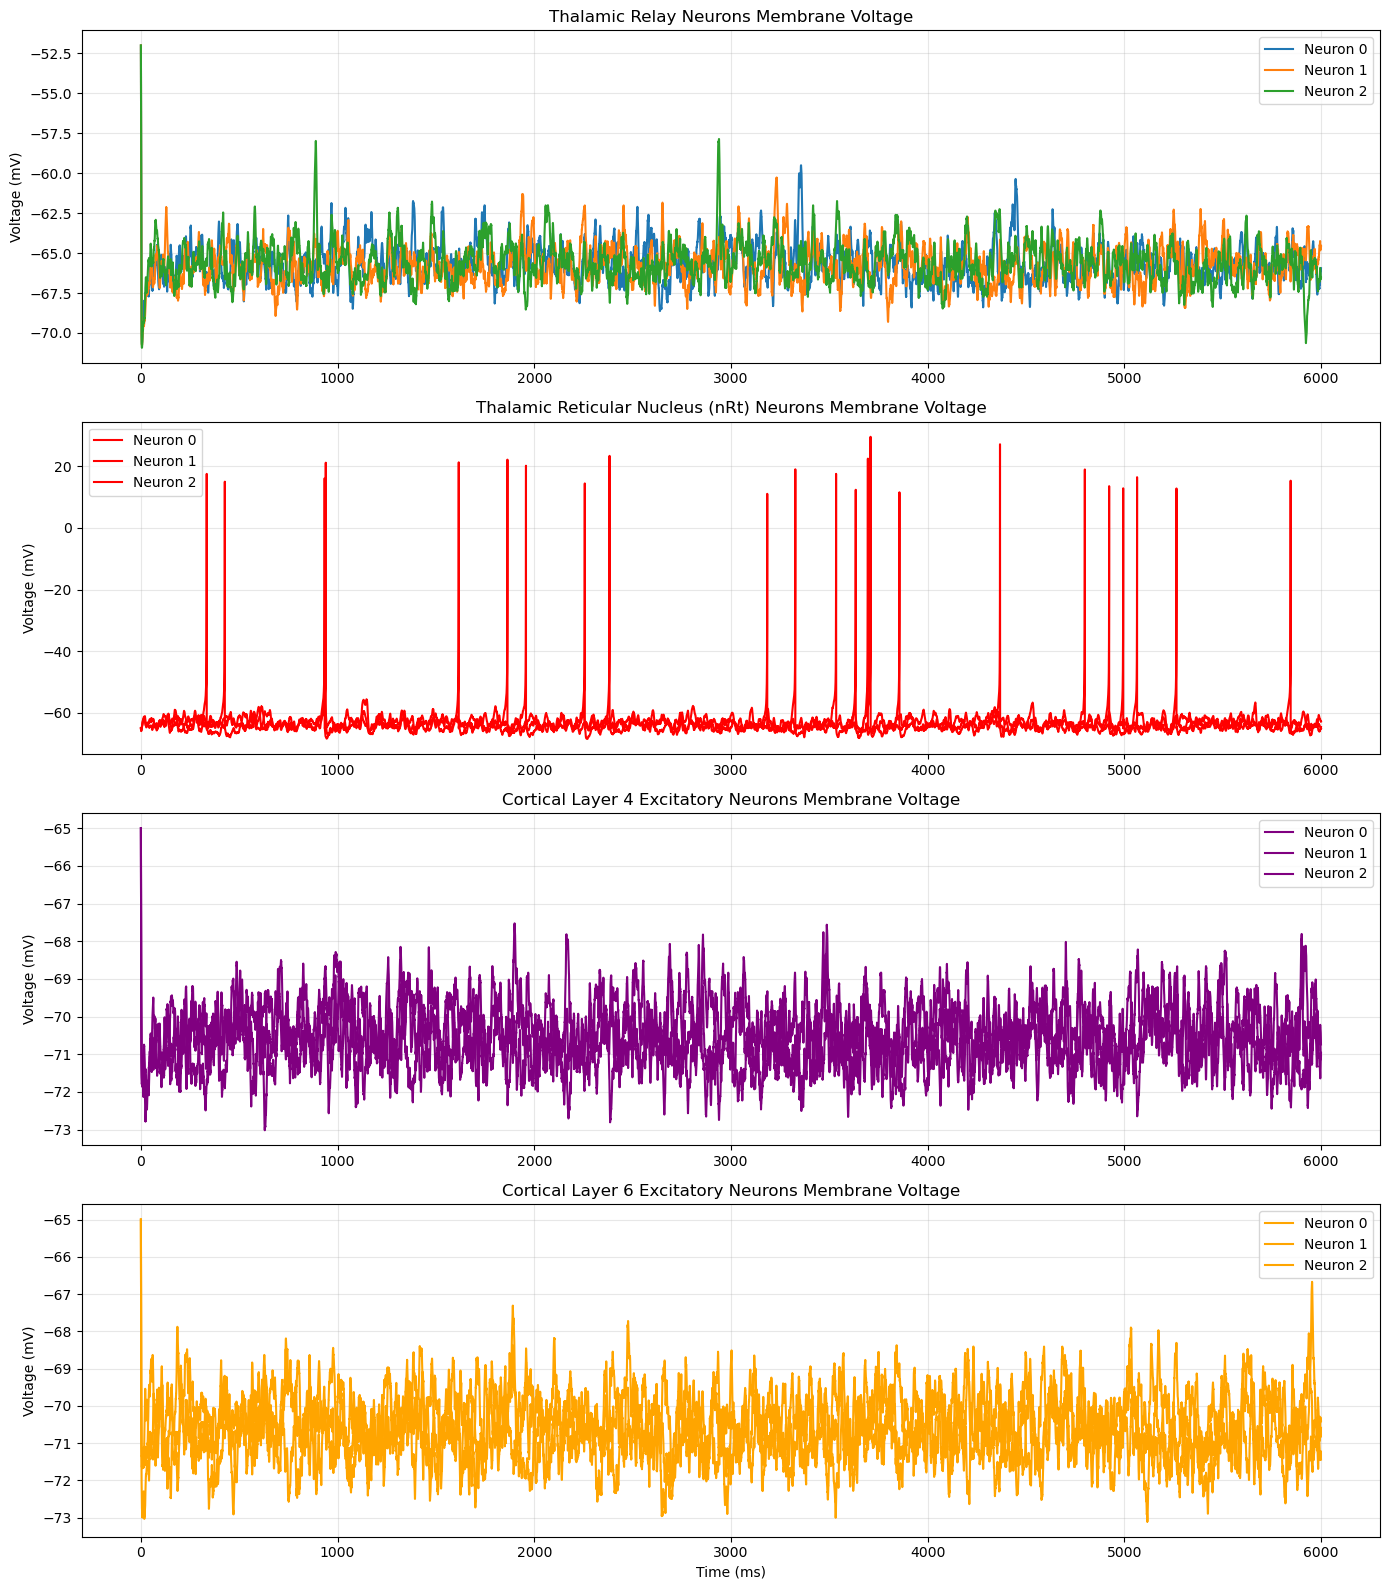

Saved plot to 'relay_neuron_dynamics.png'


<Figure size 1200x1000 with 0 Axes>


Plotting raster plots...
Saved plot to 'raster_plots.png'

Performing spectral analysis...


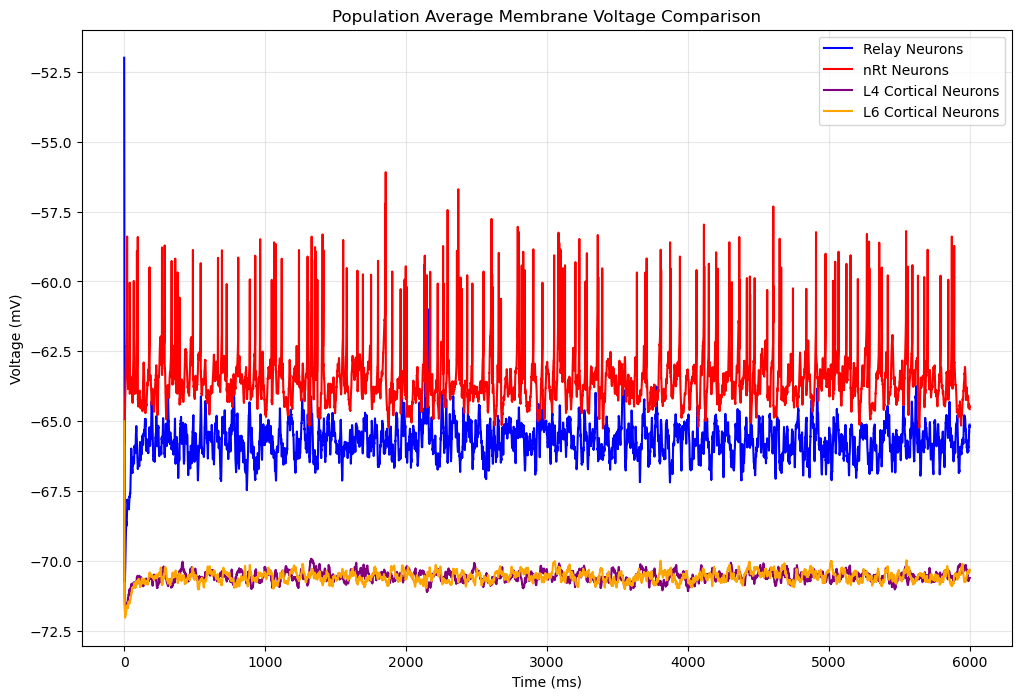

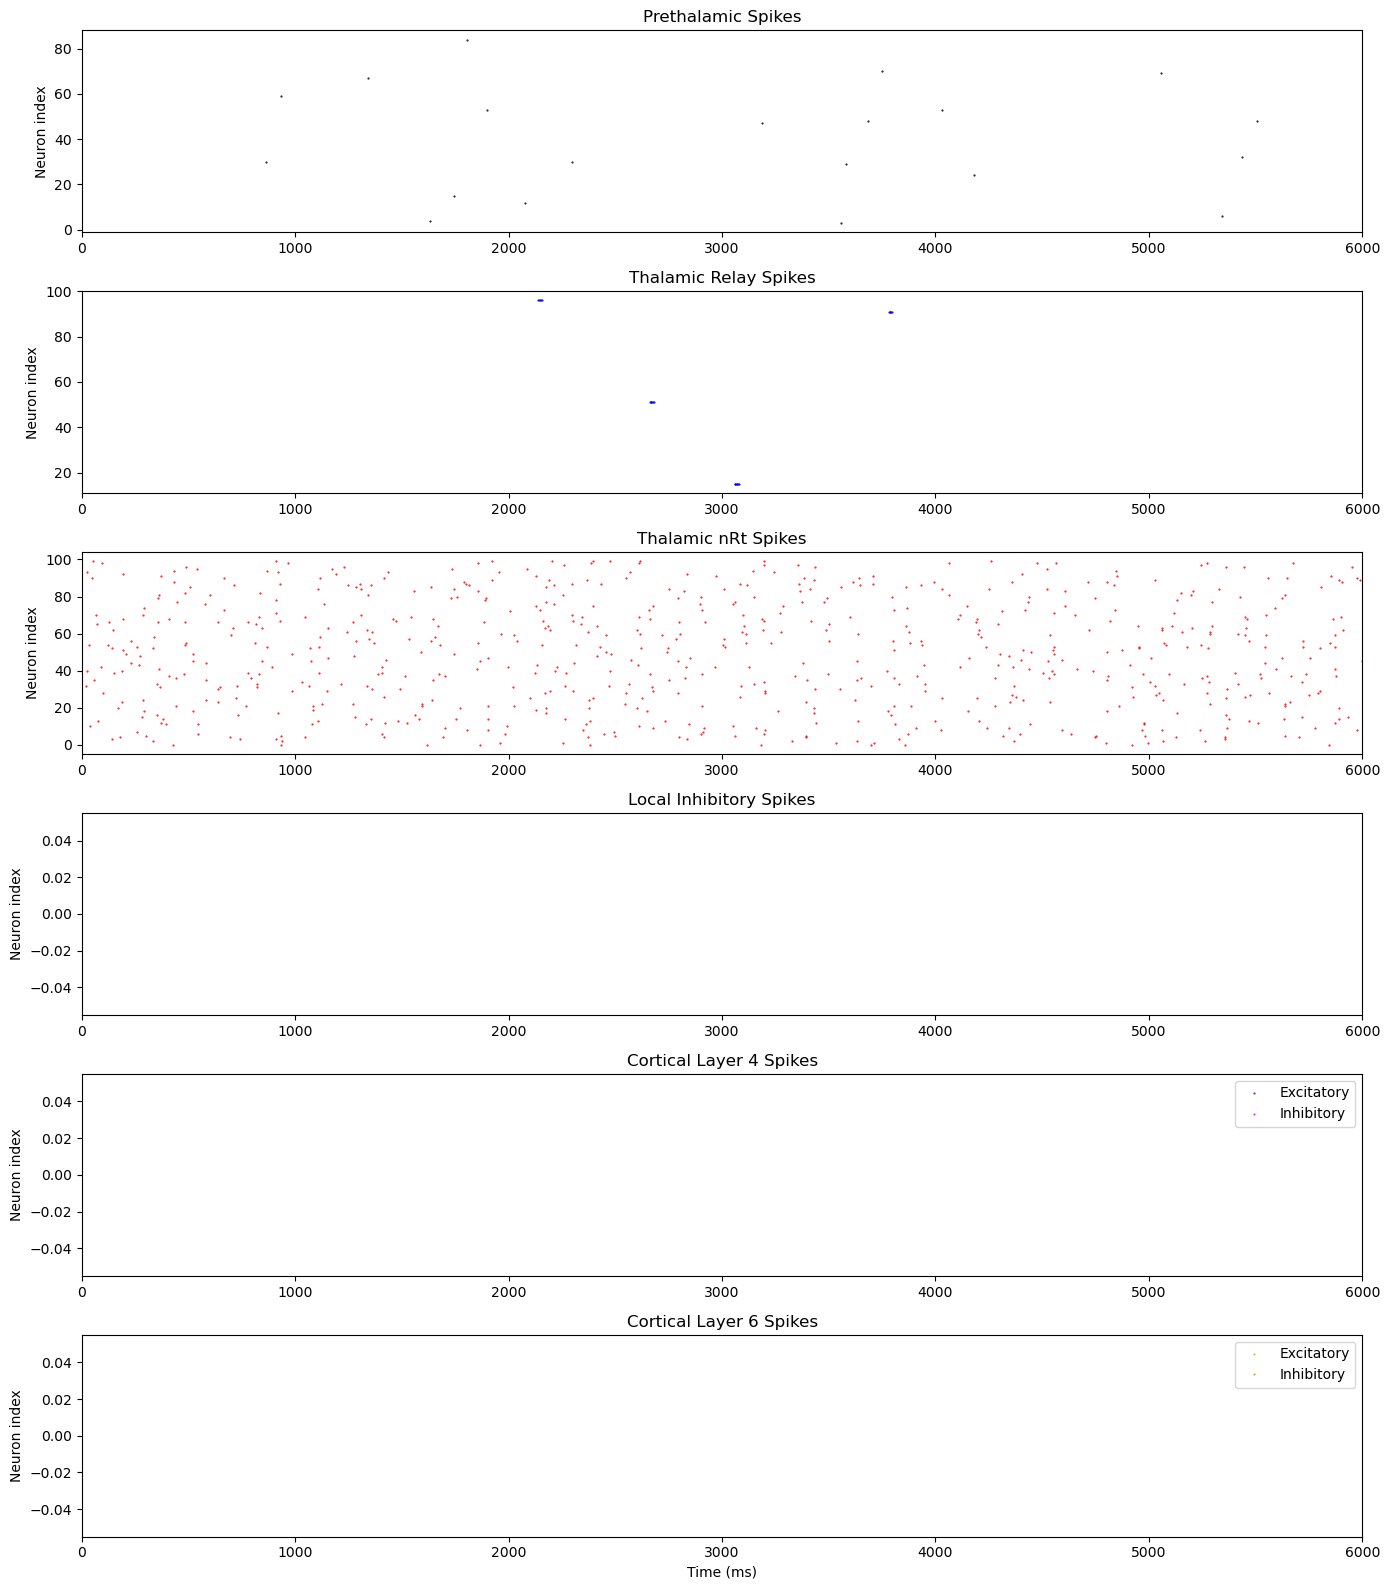

In [4]:
import os
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Set parameters
start_scope()
prefs.codegen.target = 'numpy'

# Time parameters
dt = 0.1*ms
defaultclock.dt = dt

# Neuron parameters
sigma_noise_exc_tha = 0.6
sigma_noise_inh_tha = 0.6
sigma_noise_exc = 1  # Excitatory neuron noise intensity
sigma_noise_inh = 1  # Inhibitory neuron noise intensity
sigma_noise_L23_exc = 1  # L23 excitatory neuron noise intensity
sigma_noise_L23_inh = 1  # L23 inhibitory neuron noise intensity
sigma_noise_L4_exc = 1   # L4 excitatory neuron noise intensity
sigma_noise_L4_inh = 1   # L4 inhibitory neuron noise intensity
sigma_noise_L5_exc = 1   # L5 excitatory neuron noise intensity
sigma_noise_L5_inh = 1   # L5 inhibitory neuron noise intensity
sigma_noise_L6_exc = 1   # L6 excitatory neuron noise intensity
sigma_noise_L6_inh = 1   # L6 inhibitory neuron noise intensity
v_rest = -65        # Dimensionless voltage value (represents -65mV)
tau_syn_exc = 5*ms  # Excitatory synaptic time constant
tau_syn_inh = 10*ms  # Inhibitory synaptic time constant
tau_noise = 15*ms   # Noise time constant
tau_afferent = 10*ms  # Afferent excitation time constant (new)

# Delay parameters
delay_rc = 10*ms    # Delay from relay to cortex
delay_cr = 10*ms    # Delay from cortex to relay
delay_cortical = 3*ms  # Intracortical delay

def make_layer(N_e, N_i, name, inh_type='PV', 
               sigma_noise_exc_layer=0.2, sigma_noise_inh_layer=0.2):
    # Excitatory neuron parameters (regular spiking)
    a_exc = 0.02
    b_exc = 0.2
    c_exc = -65
    d_exc = 2
    
    # Inhibitory neuron parameters (differentiated by layer as PV or SOM type)
    if inh_type == 'PV':  # Fast spiking (L4, L6)
        a_inh = 0.1
        b_inh = 0.2
        c_inh = -65
        d_inh = 2.0
    elif inh_type == 'SOM':  # Slower spiking (L2/3, L5)
        a_inh = 0.02
        b_inh = 0.2
        c_inh = -65
        d_inh = 6.0
    
    # Base equations - Using current noise (added potassium leak conductance)
    base_eqs = '''
    dv/dt = (0.04*v**2 + 5*v + 140 - u + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
    du/dt = a*(b*v - u)/ms : 1
    dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
    dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
    dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
    g_KL : 1 (constant)  # Potassium leak conductance
    E_KL : 1 (constant)
    a : 1 (constant)
    b : 1 (constant)
    c : 1 (constant)
    d : 1
    tau_noise : second (constant)
    sigma_noise : 1 (constant)
    tau_exc : second (constant)  # Excitatory synaptic time constant
    tau_inh : second (constant)  # Inhibitory synaptic time constant
    '''
    
    # Create neuron groups
    exc = NeuronGroup(N_e, base_eqs, threshold='v>=30', reset='v=c; u+=d', 
                     method='euler', name=f'exc_{name}')
    inh = NeuronGroup(N_i, base_eqs, threshold='v>=30', reset='v=c; u+=d', 
                     method='euler', name=f'inh_{name}')
    
    # Set parameters
    exc.v = c_exc
    exc.u = b_exc * c_exc
    exc.a = a_exc
    exc.b = b_exc
    exc.c = c_exc
    exc.d = d_exc
    exc.sigma_noise = sigma_noise_exc_tha
    exc.tau_noise = tau_noise
    exc.tau_exc = tau_syn_exc
    exc.tau_inh = tau_syn_inh
    exc.g_KL = 0.001
    exc.E_KL = -80
    
    inh.v = c_inh
    inh.u = b_inh * c_inh
    inh.a = a_inh
    inh.b = b_inh
    inh.c = c_inh
    inh.d = d_inh
    inh.sigma_noise = sigma_noise_exc_tha
    inh.tau_noise = tau_noise
    inh.tau_exc = tau_syn_exc
    inh.tau_inh = tau_syn_inh
    inh.g_KL = 0.001  # Default potassium leak conductance
    inh.E_KL = -80
    
    print(f"Created {name} with {N_e} exc and {N_i} inh neurons (inh_type={inh_type}), "
          f"exc noise={sigma_noise_exc_layer}, inh noise={sigma_noise_inh_layer}")
    return exc, inh

# Create cortical layer neurons
L23_exc, L23_inh = make_layer(80, 20, "L23", inh_type='SOM', 
                             sigma_noise_exc_layer=sigma_noise_L23_exc, 
                             sigma_noise_inh_layer=sigma_noise_L23_inh)

L4_exc, L4_inh = make_layer(80, 20, "L4", inh_type='PV', 
                           sigma_noise_exc_layer=sigma_noise_L4_exc, 
                           sigma_noise_inh_layer=sigma_noise_L4_inh)

L5_exc, L5_inh = make_layer(80, 20, "L5", inh_type='SOM', 
                           sigma_noise_exc_layer=sigma_noise_L5_exc, 
                           sigma_noise_inh_layer=sigma_noise_L5_inh)

L6_exc, L6_inh = make_layer(80, 20, "L6", inh_type='PV', 
                           sigma_noise_exc_layer=sigma_noise_L6_exc, 
                           sigma_noise_inh_layer=sigma_noise_L6_inh)

# Create relay neurons (thalamic neurons)
N_relay = 100
gT = 0.1
eCa = 120
tau_m_T_Ca = 5*ms
tau_h_T_Ca = 15*ms

# Modified relay neuron equations - Added afferent excitation term
relay_eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u - I_T_Ca + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
du/dt = a*(b*v - u)/ms : 1
dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
dm_T_Ca/dt = (m_inf_T_Ca - m_T_Ca)/tau_m_T_Ca : 1
dh_T_Ca/dt = (h_inf_T_Ca - h_T_Ca)/tau_h_T_Ca : 1
m_inf_T_Ca = 1/(1+exp(-(v+50)/7)) : 1
h_inf_T_Ca = 1/(1+exp((v+70)/5.5)) : 1
I_T_Ca = gT * m_T_Ca**3 * h_T_Ca * (v - eCa) : 1
g_KL : 1 (constant)  # Potassium leak conductance
E_KL : 1 (constant)  # Potassium reversal potential
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1
tau_noise : second (constant)
sigma_noise : 1 (constant)
gT : 1 (constant)
tau_m_T_Ca : second (constant)
tau_h_T_Ca : second (constant)
tau_exc : second (constant)  # Excitatory synaptic time constant
tau_inh : second (constant)  # Inhibitory synaptic time constant
'''

relay = NeuronGroup(N_relay, relay_eqs, threshold='v>=30', reset='v=c; u+=d', 
                   method='euler', name='relay')

# Set relay neuron parameters
a_relay = 0.03
b_relay = 0.25
c_relay = -52
d_relay = 0
relay.E_KL = -80
relay.v = c_relay
relay.u = b_relay * c_relay
relay.a = a_relay
relay.b = b_relay
relay.c = c_relay
relay.d = d_relay
relay.sigma_noise = sigma_noise_exc_tha
relay.tau_noise = tau_noise
relay.gT = gT
relay.tau_m_T_Ca = tau_m_T_Ca
relay.tau_h_T_Ca = tau_h_T_Ca
relay.g_KL = 0.001  # Default potassium leak conductance
relay.tau_exc = tau_syn_exc
relay.tau_inh = tau_syn_inh

# Create nRt neurons (thalamic reticular nucleus)
N_nrt = 100
gT_nrt = 0.1  # Modified: Added T-type calcium channels, weaker conductance
tau_h_T_Ca_nrt = 15*ms

# Modified nrt neuron equations - Added afferent excitation term
nrt_eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u - I_T_Ca + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
du/dt = a*(b*v - u)/ms : 1
dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
dm_T_Ca/dt = (m_inf_T_Ca - m_T_Ca)/tau_m_T_Ca : 1
dh_T_Ca/dt = (h_inf_T_Ca - h_T_Ca)/tau_h_T_Ca : 1
m_inf_T_Ca = 1/(1+exp(-(v+50)/7)) : 1
h_inf_T_Ca = 1/(1+exp((v+70)/5.5)) : 1
I_T_Ca = gT * m_T_Ca**3 * h_T_Ca * (v - eCa) : 1
g_KL : 1 (constant)  # Potassium leak conductance
E_KL : 1 (constant)  # Potassium reversal potential
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1
tau_syn : second (constant)
gT : 1 (constant)
tau_m_T_Ca : second (constant)
tau_h_T_Ca : second (constant)
eCa : 1 (constant)
tau_noise : second (constant)
sigma_noise : 1 (constant)
tau_exc : second (constant)  # Excitatory synaptic time constant
tau_inh : second (constant)  # Inhibitory synaptic time constant
'''

nrt = NeuronGroup(N_nrt, nrt_eqs, threshold='v>=30', reset='v=c; u+=d', 
                 method='euler', name='nrt')

# Set nRt neuron parameters tonic spiking
a_nrt = 0.02
b_nrt = 0.25
c_nrt = -65
d_nrt = 2
nrt.v = c_nrt
nrt.u = b_nrt * c_nrt
nrt.a = a_nrt
nrt.b = b_nrt
nrt.c = c_nrt
nrt.d = d_nrt
nrt.gT = gT_nrt
nrt.tau_m_T_Ca = tau_m_T_Ca
nrt.tau_h_T_Ca = tau_h_T_Ca_nrt
nrt.eCa = eCa
nrt.sigma_noise = sigma_noise_inh_tha
nrt.tau_noise = tau_noise
nrt.g_KL = 0.006  # Default potassium leak conductance
nrt.E_KL = -70
nrt.tau_exc = tau_syn_exc
nrt.tau_inh = tau_syn_inh

# Create thalamic local inhibitory neurons
N_local_inh = 100
# Modified local inhibitory neuron equations - Added afferent excitation term
local_inh_eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
du/dt = a*(b*v - u)/ms : 1
dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
g_KL : 1 (constant)  # Potassium leak conductance
E_KL : 1 (constant)  # Potassium reversal potential
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1
tau_exc : second (constant)  # Excitatory synaptic time constant
tau_inh : second (constant)  # Inhibitory synaptic time constant
tau_noise : second (constant)
sigma_noise : 1 (constant)
'''

local_inh = NeuronGroup(N_local_inh, local_inh_eqs, threshold='v>=30', 
                      reset='v=c; u+=d', method='euler', name='local_inh')

# Set local inhibitory neuron parameters
a_local = 0.1
b_local = 0.2
c_local = -65
d_local = 2.0
local_inh.v = c_local
local_inh.u = b_local * c_local
local_inh.a = a_local
local_inh.b = b_local
local_inh.c = c_local
local_inh.d = d_local
local_inh.sigma_noise = sigma_noise_inh_tha
local_inh.tau_noise = tau_noise
local_inh.g_KL = 0.006  # Default potassium leak conductance
local_inh.tau_exc = tau_syn_exc
local_inh.tau_inh = tau_syn_inh

# Create Prethalamic neurons
prethalamic_eqs = '''
dv/dt = (0.04*v**2 + 5*v + 140 - u + I_exc + I_inh + I_noise - g_KL*(v - E_KL))/ms : 1
du/dt = a*(b*v - u)/ms : 1
dI_noise/dt = -I_noise/tau_noise + sigma_noise*sqrt(2/tau_noise)*xi : 1
dI_exc/dt = -I_exc/tau_exc : 1  # Excitatory synaptic current
dI_inh/dt = -I_inh/tau_inh : 1  # Inhibitory synaptic current
g_KL : 1 (constant)  # Potassium leak conductance
E_KL : 1 (constant)  # Potassium reversal potential
a : 1 (constant)
b : 1 (constant)
c : 1 (constant)
d : 1
tau_exc : second (constant)  # Excitatory synaptic time constant
tau_inh : second (constant)  # Inhibitory synaptic time constant
tau_noise : second (constant)
sigma_noise : 1 (constant)
'''

N_prethalamic = 100
prethalamic = NeuronGroup(N_prethalamic, prethalamic_eqs, threshold='v>=30', 
                         reset='v=c; u+=d', method='euler', name='prethalamic')

# Set Prethalamic neuron parameters
a_pre = 0.02
b_pre = 0.2
c_pre = -65
d_pre = 6
prethalamic.v = c_pre
prethalamic.u = b_pre * c_pre
prethalamic.a = a_pre
prethalamic.b = b_pre
prethalamic.c = c_pre
prethalamic.d = d_pre
prethalamic.sigma_noise = sigma_noise_exc
prethalamic.tau_noise = tau_noise
prethalamic.g_KL = 0.006  # Default potassium leak conductance
prethalamic.E_KL = -80
prethalamic.tau_exc = tau_syn_exc
prethalamic.tau_inh = tau_syn_inh

# Set time constants after creating neuron groups
# For cortical neurons
for layer in [L23_exc, L23_inh, L4_exc, L4_inh, L5_exc, L5_inh, L6_exc, L6_inh]:
    layer.tau_exc = tau_syn_exc
    layer.tau_inh = tau_syn_inh

# Sleep stage setup function
# === Create 100Hz background input ===
print("\nCreating 100Hz background input...")

# Create independent 100Hz Poisson input for each thalamic neuron
background_relay = PoissonGroup(N_relay, rates=100*Hz, name='background_relay')
background_nrt = PoissonGroup(N_nrt, rates=100*Hz, name='background_nrt')
background_local_inh = PoissonGroup(N_local_inh, rates=100*Hz, name='background_local_inh')

# Create background input connections
bg2relay = Synapses(background_relay, relay, 
                   model='w:1', 
                   on_pre='I_exc_post += w',
                   delay=0*ms, 
                   name='bg2relay')
# Add connections
bg2relay.connect()

bg2nrt = Synapses(background_nrt, nrt, 
                 model='w:1', 
                 on_pre='I_exc_post += w',
                 delay=0*ms, 
                 name='bg2nrt')
# Add connections
bg2nrt.connect()

bg2local_inh = Synapses(background_local_inh, local_inh, 
                       model='w:1', 
                       on_pre='I_exc_post += w',
                       delay=0*ms, 
                       name='bg2local_inh')
# Add connections
bg2local_inh.connect()

# Set initial weights
bg2relay.w = 0.0
bg2nrt.w = 0.0
bg2local_inh.w = 0.0

# Sleep stage setup function - Modified to use g_input for background input strength
def set_sleep_stage(stage):
    """Set parameters for different sleep stages (based on Li et al. 2017)"""
    # List of all neuron groups
    all_neuron_groups = [prethalamic, relay, nrt, local_inh, 
                        L23_exc, L23_inh, L4_exc, L4_inh,
                        L5_exc, L5_inh, L6_exc, L6_inh]
    
    if stage == "wake_eyes_closed":  # α oscillations
        # Thalamic parameters (Table 1)
        relay.g_KL = 0.00      # TC cells completely block potassium leak current
        nrt.g_KL = 0.01      # RE cells reduce potassium leak conductance
        local_inh.g_KL = 0.02  # IN cells increase potassium leak conductance
        relay.a = 0.02
        relay.b = 0.4
        relay.c = -65 
        relay.d = 2
        
        # Set background input strength (g_input)
        bg2relay.w = 0.4     # TC cells medium input strength
        bg2nrt.w = 0.2      # RE cells medium input strength
        bg2local_inh.w = 0.02 # IN cells medium input strength
        
    elif stage == "wake_eyes_open":  # γ oscillations
        # Thalamic parameters (Table 1)
        relay.g_KL = 0.1
        nrt.g_KL = 0.05
        local_inh.g_KL = 0.02
        relay.a = 0.02
        relay.b = 0.4
        relay.c = -65
        relay.d = 2
        L4_inh.tau_inh = 5*ms
        L23_inh.tau_inh = 5*ms
        L5_inh.tau_inh = 5*ms
        L6_inh.tau_inh = 5*ms
        
        L4_inh.g_KL = 0.01
        L23_inh.g_KL = 0.01
        L5_inh.g_KL = 0.01
        L6_inh.g_KL = 0.01
        L4_exc.g_KL = 0.01
        L23_exc.g_KL = 0.01
        L5_exc.g_KL = 0.01
        L6_exc.g_KL = 0.01

        
        # Set background input strength (g_input)
        bg2relay.w = 0.5     # TC cells strong input strength 0.7
        bg2nrt.w = 0.05      # RE cells medium input strength 0.02
        bg2local_inh.w = 0.02 # IN cells medium input strength 0.01

        relay.gT = 0  # Original 0.1 → reduced by 50%
        nrt.gT = 0  # Original 0.1 → reduced by 50%
        nrt2relay.w = 0.1

        # Weaken cortical L6 to Relay excitatory feedback, core of large cortex-thalamus loop
        # L62relay.w = 0.1
        
    elif stage == "N1":
        # Neuromodulation levels
        relay.g_KL = 0.15      # TC medium potassium leak conductance
        nrt.g_KL = 0.15       # RE medium potassium leak conductance
        local_inh.g_KL = 0.05  # IN medium potassium leak conductance
        
        # Set background input strength (g_input)
        bg2relay.w = 0.08     # TC cells medium input strength
        bg2nrt.w = 0.0       # RE cells medium input strength
        bg2local_inh.w = 0.01  # IN cells medium input strength
        relay.gT = 0.1 # Original 0.1 → reduced by 50%
        nrt.gT = 0.1
        relay.tau_m_T_Ca = 15*ms  # Adjusted from 20ms
        relay.tau_h_T_Ca = 25*ms  # <--- Significantly shortened from 40ms to 25ms
            
    elif stage == "N2":  # Moderate sleep (spindles and K-complexes)
        # Neuromodulation levels
        relay.g_KL = 0.2      # TC high potassium leak conductance 0.12
        nrt.g_KL = 0.23       # RE high potassium leak conductance 0.05 
        local_inh.g_KL = 0.016   # IN low potassium leak conductance 0.01
        
        # Set background input strength (g_input)
        bg2relay.w = 0.06     # TC cells weak input strength
        bg2nrt.w = 0.04        # RE cells weak input strength
        bg2local_inh.w = 0.015  # IN cells weak input strength

        L4_inh.g_KL = 0.03
        L23_inh.g_KL = 0.03
        L5_inh.g_KL = 0.03
        L6_inh.g_KL = 0.03
        L4_exc.g_KL = 0.03
        L23_exc.g_KL = 0.03
        L5_exc.g_KL = 0.03
        L6_exc.g_KL = 0.03

        nrt.gT = 0.15
        relay.gT = 0.15

        # L62relay.w = 0.1

        
    elif stage == "N3":  # Deep sleep (δ waves dominant)
        # Neuromodulation levels
        relay.g_KL = 0.25      # TC high potassium leak conductance 0.12
        nrt.g_KL = 0.27       # RE high potassium leak conductance 0.05 
        local_inh.g_KL = 0.016   # IN low potassium leak conductance 0.01
        
        # Set background input strength (g_input)
        bg2relay.w = 0.06     # TC cells weak input strength
        bg2nrt.w = 0.04        # RE cells weak input strength
        bg2local_inh.w = 0.01  # IN cells weak input strength

        L4_inh.g_KL = 0.05
        L23_inh.g_KL = 0.05
        L5_inh.g_KL = 0.05
        L6_inh.g_KL = 0.05
        L4_exc.g_KL = 0.05
        L23_exc.g_KL = 0.05
        L5_exc.g_KL = 0.05
        L6_exc.g_KL = 0.05

        nrt.gT = 0.7
        relay.gT = 0.7

        L62relay.w = 0.45  # Original global setting: 0.25
        L62nrt.w = 0.50    # Original global setting: 0.35

                
    elif stage == "REM":  # REM sleep (similar to wake state)
        # Thalamic parameters (similar to wake)
        # Set background input strength (g_input)
        bg2relay.w = 0.2    # TC cells weak input strength
        bg2nrt.w = 0.1        # RE cells weak input strength
        bg2local_inh.w = 0.03  # IN cells weak input strength
        
        relay.g_KL = 0.15
        nrt.g_KL = 0.05
        local_inh.g_KL = 0.02
        relay.a = 0.02
        relay.b = 0.2
        relay.c = -65
        relay.d = 2
        
        L4_inh.g_KL = 0.02
        L23_inh.g_KL = 0.02
        L5_inh.g_KL = 0.02
        L6_inh.g_KL = 0.02
        L4_exc.g_KL = 0.02
        L23_exc.g_KL = 0.02
        L5_exc.g_KL = 0.02
        L6_exc.g_KL = 0.02

        nrt.gT = 0.0
        relay.gT = 0.0
        L4_inh.tau_inh = 5*ms
        L23_inh.tau_inh = 5*ms
        L5_inh.tau_inh = 5*ms
        L6_inh.tau_inh = 5*ms
        nrt2relay.w = 0.1


    else:  # Default state
        # Restore default parameters
        relay.g_KL = 0.01
        nrt.g_KL = 0.01
        local_inh.g_KL = 0.01
        relay.a = a_relay
        relay.b = b_relay
        relay.c = c_relay
        relay.d = d_relay
        relay.tau_m_T_Ca = tau_m_T_Ca
        relay.tau_h_T_Ca = tau_h_T_Ca
        
        # Set default background input strength
        bg2relay.w = 0.1
        bg2nrt.w = 0.1
        bg2local_inh.w = 0.1
    
    print(f"\nSet sleep stage: {stage}")
    print(f"Relay g_KL: {relay.g_KL[0]}, g_input: {bg2relay.w[0]}")
    print(f"nRt g_KL: {nrt.g_KL[0]}, g_input: {bg2nrt.w[0]}")
    print(f"LocalInh g_KL: {local_inh.g_KL[0]}, g_input: {bg2local_inh.w[0]}")
    # print(f"Input rates: {input_group.rates}, Pre2Relay w: {prethalamic2relay.w[0]}")


# Create synaptic connections
print("\nCreating synapses...")

# 1. Prethalamic → Relay
prethalamic2relay = Synapses(prethalamic, relay, model='w:1', 
                             on_pre='I_exc_post += w', delay=10*ms, name='prethalamic2relay')
prethalamic2relay.connect(p=0.3)
prethalamic2relay.w = 0.0

# 2. Prethalamic → Local inhibitory neurons
prethalamic2local_inh = Synapses(prethalamic, local_inh, model='w:1', 
                                on_pre='I_exc_post += w', delay=5*ms, name='prethalamic2local_inh')
prethalamic2local_inh.connect(p=0.25)
prethalamic2local_inh.w = 0.0

# 4. Relay → nRt
relay2nrt = Synapses(relay, nrt, model='w:1', 
                    on_pre='I_exc_post += w', delay=10*ms, name='relay2nrt')
relay2nrt.connect(p=0.45)
relay2nrt.w = 0.35

# 5. nRt → Relay
nrt2relay = Synapses(nrt, relay, model='w:1', 
                    on_pre='I_inh_post -= w', delay=10*ms, name='nrt2relay')
nrt2relay.connect(p=0.3)
nrt2relay.w = 0.3

# 6. nRt → nRt
nrt2nrt = Synapses(nrt, nrt, model='w:1', 
                  on_pre='I_inh_post -= w', delay=2*ms, name='nrt2nrt')
nrt2nrt.connect(p=0.25)
nrt2nrt.w = 0.2

# 8. Local inhibitory neurons → relay
relay2local_inh = Synapses(local_inh, relay, model='w:1', 
                         on_pre='I_inh_post -= w', delay=10*ms, name='relay2local_inh')
relay2local_inh.connect(p=0.2)
relay2local_inh.w = 0.3

# 9. Relay → L4
relay2L4_exc = Synapses(relay, L4_exc, model='w:1', 
                       on_pre='I_exc_post += w', delay=delay_rc, name='relay2L4_exc')
relay2L4_exc.connect(p=0.3)
relay2L4_exc.w = 0.3

relay2L4_inh = Synapses(relay, L4_inh, model='w:1', 
                       on_pre='I_exc_post += w', delay=delay_rc, name='relay2L4_inh')
relay2L4_inh.connect(p=0.3)
relay2L4_inh.w = 0.25

# 10. Relay → L6
relay2L6_exc = Synapses(relay, L6_exc, model='w:1', 
                       on_pre='I_exc_post += w', delay=delay_rc, name='relay2L6_exc')
relay2L6_exc.connect(p=0.3)
relay2L6_exc.w = 0.35  # Modified: increased weight

relay2L6_inh = Synapses(relay, L6_inh, model='w:1', 
                       on_pre='I_exc_post += w', delay=delay_rc, name='relay2L6_inh')
relay2L6_inh.connect(p=0.3)
relay2L6_inh.w = 0.25

# 11. L4 → L23
L42L23_exc = Synapses(L4_exc, L23_exc, model='w:1', 
                     on_pre='I_exc_post += w', delay=delay_cortical, name='L42L23_exc')
L42L23_exc.connect(p=0.4)
L42L23_exc.w = 0.4

L42L23_inh = Synapses(L4_exc, L23_inh, model='w:1', 
                     on_pre='I_exc_post += w', delay=delay_cortical, name='L42L23_inh')
L42L23_inh.connect(p=0.4)
L42L23_inh.w = 0.25

# 12. L23 → L5
L232L5_exc = Synapses(L23_exc, L5_exc, model='w:1', 
                     on_pre='I_exc_post += w', delay=delay_cortical, name='L232L5_exc')
L232L5_exc.connect(p=0.4)
L232L5_exc.w = 0.45

L232L5_inh = Synapses(L23_exc, L5_inh, model='w:1', 
                     on_pre='I_exc_post += w', delay=delay_cortical, name='L232L5_inh')
L232L5_inh.connect(p=0.4)
L232L5_inh.w = 0.25

# 13. L5 → L6
L52L6_exc = Synapses(L5_exc, L6_exc, model='w:1', 
                    on_pre='I_exc_post += w', delay=delay_cortical, name='L52L6_exc')
L52L6_exc.connect(p=0.3)
L52L6_exc.w = 0.35

L52L6_inh = Synapses(L5_exc, L6_inh, model='w:1', 
                    on_pre='I_exc_post += w', delay=delay_cortical, name='L52L6_inh')
L52L6_inh.connect(p=0.3)
L52L6_inh.w = 0.25

# 14. L6 → Relay
L62relay = Synapses(L6_exc, relay, model='w:1', 
                   on_pre='I_exc_post += w', delay=delay_cr, name='L62relay')
L62relay.connect(p=0.2)
L62relay.w = 0.25

# 15. L6 → nRt
L62nrt = Synapses(L6_exc, nrt, model='w:1', 
                 on_pre='I_exc_post += w', delay=delay_cr, name='L62nrt')
L62nrt.connect(p=0.3)
L62nrt.w = 0.35

# 16. L6 → Local inhibitory neurons
L62local_inh = Synapses(L6_exc, local_inh, model='w:1', 
                      on_pre='I_exc_post += w', delay=delay_cr, name='L62local_inh')
L62local_inh.connect(p=0.33)
L62local_inh.w = 0.3

# 17. L5 → Relay
L52relay = Synapses(L5_exc, relay, model='w:1', 
                   on_pre='I_exc_post += w', delay=delay_cr, name='L52relay')
L52relay.connect(p=0.35)
L52relay.w = 0.35

# ------------------------------------------------
# 6. Intra-layer E-I connections (key for PING mechanism)
# ------------------------------------------------
# <--- New: L2/3 internal connections
L23_exc2inh = Synapses(L23_exc, L23_inh, on_pre='I_exc_post += w', delay=1*ms, model='w:1')
L23_exc2inh.connect(p=0.4)
L23_exc2inh.w = 0.4
L23_inh2exc = Synapses(L23_inh, L23_exc, on_pre='I_inh_post -= w', delay=1*ms, model='w:1')
L23_inh2exc.connect(p=0.4)
L23_inh2exc.w = 0.4

# <--- New: L4 internal connections
L4_exc2inh = Synapses(L4_exc, L4_inh, on_pre='I_exc_post += w', delay=1*ms, model='w:1')
L4_exc2inh.connect(p=0.4)
L4_exc2inh.w = 0.4
L4_inh2exc = Synapses(L4_inh, L4_exc, on_pre='I_inh_post -= w', delay=1*ms, model='w:1')
L4_inh2exc.connect(p=0.4)
L4_inh2exc.w = 0.3

# <--- New: L5 internal connections
L5_exc2inh = Synapses(L5_exc, L5_inh, on_pre='I_exc_post += w', delay=1*ms, model='w:1')
L5_exc2inh.connect(p=0.4)
L5_exc2inh.w = 0.4
L5_inh2exc = Synapses(L5_inh, L5_exc, on_pre='I_inh_post -= w', delay=1*ms, model='w:1')
L5_inh2exc.connect(p=0.4)
L5_inh2exc.w = 0.4

# <--- New: L6 internal connections
L6_exc2inh = Synapses(L6_exc, L6_inh, on_pre='I_exc_post += w', delay=1*ms, model='w:1')
L6_exc2inh.connect(p=0.4)
L6_exc2inh.w = 0.4
L6_inh2exc = Synapses(L6_inh, L6_exc, on_pre='I_inh_post -= w', delay=1*ms, model='w:1')
L6_inh2exc.connect(p=0.4)
L6_inh2exc.w = 0.3

# 18. Inter-layer inhibitory connections
L4_inh2L23_exc = Synapses(L4_inh, L23_exc, model='w:1', 
                         on_pre='I_inh_post -= w', delay=delay_cortical, name='L4_inh2L23_exc')
L4_inh2L23_exc.connect(p=0.2)
L4_inh2L23_exc.w = 0.2

L4_inh2L23_inh = Synapses(L4_inh, L23_inh, model='w:1', 
                         on_pre='I_inh_post -= w', delay=delay_cortical, name='L4_inh2L23_inh')
L4_inh2L23_inh.connect(p=0.2)
L4_inh2L23_inh.w = 0.2

L23_inh2L5_exc = Synapses(L23_inh, L5_exc, model='w:1', 
                         on_pre='I_inh_post -= w', delay=delay_cortical, name='L23_inh2L5_exc')
L23_inh2L5_exc.connect(p=0.2)
L23_inh2L5_exc.w = 0.2

L23_inh2L5_inh = Synapses(L23_inh, L5_inh, model='w:1', 
                         on_pre='I_inh_post -= w', delay=delay_cortical, name='L23_inh2L5_inh')
L23_inh2L5_inh.connect(p=0.2)
L23_inh2L5_inh.w = 0.2

L5_inh2L6_exc = Synapses(L5_inh, L6_exc, model='w:1', 
                        on_pre='I_inh_post -= w', delay=delay_cortical, name='L5_inh2L6_exc')
L5_inh2L6_exc.connect(p=0.2)
L5_inh2L6_exc.w = 0.2

L5_inh2L6_inh = Synapses(L5_inh, L6_inh, model='w:1', 
                        on_pre='I_inh_post -= w', delay=delay_cortical, name='L5_inh2L6_inh')
L5_inh2L6_inh.connect(p=0.2)
L5_inh2L6_inh.w = 0.3

L6_inh2L6_exc = Synapses(L6_inh, L6_exc, model='w:1', 
                        on_pre='I_inh_post -= w', delay=delay_cortical, name='L6_inh2L6_exc')
L6_inh2L6_exc.connect(p=0.2)
L6_inh2L6_exc.w = 0.2

# Set sleep stage (choose stage to simulate here)
sleep_stage = "N3"  # options: "wake_eyes_closed", "wake_eyes_open", "N1", "N2", "N3", "REM"
set_sleep_stage(sleep_stage)

# Create monitors
print("\nSetting up monitors...")

# Function to monitor population voltage
def monitor_population_voltage(group, sample_size=20, name=""):
    indices = np.random.choice(len(group), min(sample_size, len(group)), replace=False)
    return StateMonitor(group, 'v', record=indices, name=f'pop_v_{name}')

prethalamic_spike_mon = SpikeMonitor(prethalamic)
relay_spike_mon = SpikeMonitor(relay)
nrt_spike_mon = SpikeMonitor(nrt)
local_inh_spike_mon = SpikeMonitor(local_inh)
L23_exc_spike_mon = SpikeMonitor(L23_exc)
L23_inh_spike_mon = SpikeMonitor(L23_inh)
L4_exc_spike_mon = SpikeMonitor(L4_exc)
L4_inh_spike_mon = SpikeMonitor(L4_inh)
L5_exc_spike_mon = SpikeMonitor(L5_exc)
L5_inh_spike_mon = SpikeMonitor(L5_inh)
L6_exc_spike_mon = SpikeMonitor(L6_exc)
L6_inh_spike_mon = SpikeMonitor(L6_inh)

# Voltage monitors - Record all neurons
print("Creating voltage monitors for all neurons...")

# Record membrane voltage of all relay neurons
pop_mon_relay = StateMonitor(relay, 'v', record=True, name='pop_v_relay_all')

# Record membrane voltage of all nrt neurons
pop_mon_nrt = StateMonitor(nrt, 'v', record=True, name='pop_v_nrt_all')

# Record membrane voltage of all local inhibitory neurons
pop_mon_local_inh = StateMonitor(local_inh, 'v', record=True, name='pop_v_local_inh_all')

# Record membrane voltage of all L4 excitatory neurons
pop_mon_L4_exc = StateMonitor(L4_exc, 'v', record=True, name='pop_v_L4_exc_all')

# Record membrane voltage of all L6 excitatory neurons
pop_mon_L6_exc = StateMonitor(L6_exc, 'v', record=True, name='pop_v_L6_exc_all')

# Monitor neuron voltage
prethalamic_state_mon = StateMonitor(prethalamic, 'v', record=[0, 1, 2])
relay_state_mon = StateMonitor(relay, ['v', 'I_T_Ca'], record=[0, 1, 2])
nrt_state_mon = StateMonitor(nrt, 'v', record=[0, 1, 2])
local_inh_state_mon = StateMonitor(local_inh, 'v', record=[0, 1, 2])
L4_exc_state_mon = StateMonitor(L4_exc, 'v', record=[0, 1, 2])
L6_exc_state_mon = StateMonitor(L6_exc, 'v', record=[0, 1, 2])
# Add StateMonitor for L23_exc and L5_exc
L23_exc_state_mon = StateMonitor(L23_exc, 'v', record=True, name='L23_exc_state_mon')
L5_exc_state_mon = StateMonitor(L5_exc, 'v', record=True, name='L5_exc_state_mon')

# Create population voltage monitors using function
pop_mon_relay = monitor_population_voltage(relay, 20, "relay")
pop_mon_nrt = monitor_population_voltage(nrt, 20, "nrt")
pop_mon_local_inh = monitor_population_voltage(local_inh, 20, "local_inh")
pop_mon_L4_exc = monitor_population_voltage(L4_exc, 20, "L4_exc")
pop_mon_L6_exc = monitor_population_voltage(L6_exc, 20, "L6_exc")


# Run simulation
print("\nStarting simulation...")
duration = 6000*ms
run(duration, report='text')

# Add save code after simulation
print("\nSaving monitoring data...")

# Define save directory
save_dir = "simulation_data_N3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save spike data
def save_spike_monitor(monitor, filename):
    spike_times = np.array(monitor.t)  # Spike times (seconds)
    spike_indices = np.array(monitor.i)  # Neuron indices
    np.save(os.path.join(save_dir, f"{filename}_times.npy"), spike_times)
    np.save(os.path.join(save_dir, f"{filename}_indices.npy"), spike_indices)
    print(f"Saved {filename} spike data: {len(spike_times)} spikes")

# Save voltage data
def save_voltage_monitor(monitor, filename):
    voltage_data = np.array(monitor.v)  # Voltage matrix (neurons × time points)
    time_points = np.array(monitor.t)  # Time points (seconds)
    np.save(os.path.join(save_dir, f"{filename}_voltage.npy"), voltage_data)
    np.save(os.path.join(save_dir, f"{filename}_time.npy"), time_points)
    print(f"Saved {filename} voltage data: {voltage_data.shape}")

# Save all monitor data
save_spike_monitor(prethalamic_spike_mon, "prethalamic_spikes")
save_spike_monitor(relay_spike_mon, "relay_spikes")
save_spike_monitor(nrt_spike_mon, "nrt_spikes")
save_spike_monitor(local_inh_spike_mon, "local_inh_spikes")
save_spike_monitor(L23_exc_spike_mon, "L23_exc_spikes")
save_spike_monitor(L23_inh_spike_mon, "L23_inh_spikes")
save_spike_monitor(L4_exc_spike_mon, "L4_exc_spikes")
save_spike_monitor(L4_inh_spike_mon, "L4_inh_spikes")
save_spike_monitor(L5_exc_spike_mon, "L5_exc_spikes")
save_spike_monitor(L5_inh_spike_mon, "L5_inh_spikes")
save_spike_monitor(L6_exc_spike_mon, "L6_exc_spikes")
save_spike_monitor(L6_inh_spike_mon, "L6_inh_spikes")

save_voltage_monitor(pop_mon_relay, "relay_voltage")
save_voltage_monitor(pop_mon_nrt, "nrt_voltage")
save_voltage_monitor(pop_mon_local_inh, "local_inh_voltage")
save_voltage_monitor(pop_mon_L4_exc, "L4_exc_voltage")
save_voltage_monitor(pop_mon_L6_exc, "L6_exc_voltage")

# Print results
print("\nSimulation results:")
print(f"Prethalamic neurons spiked {prethalamic_spike_mon.num_spikes} times")
print(f"Relay neurons spiked {relay_spike_mon.num_spikes} times")
print(f"nRt neurons spiked {nrt_spike_mon.num_spikes} times")
print(f"Local inhibitory neurons spiked {local_inh_spike_mon.num_spikes} times")
print(f"L23 excitatory neurons spiked {L23_exc_spike_mon.num_spikes} times")
print(f"L23 inhibitory neurons spiked {L23_inh_spike_mon.num_spikes} times")
print(f"L4 excitatory neurons spiked {L4_exc_spike_mon.num_spikes} times")
print(f"L4 inhibitory neurons spiked {L4_inh_spike_mon.num_spikes} times")
print(f"L5 excitatory neurons spiked {L5_exc_spike_mon.num_spikes} times")
print(f"L5 inhibitory neurons spiked {L5_inh_spike_mon.num_spikes} times")
print(f"L6 excitatory neurons spiked {L6_exc_spike_mon.num_spikes} times")
print(f"L6 inhibitory neurons spiked {L6_inh_spike_mon.num_spikes} times")

# Plot membrane voltage changes in different regions
plt.figure(figsize=(14, 16))

# 1. Relay neuron membrane voltage
plt.subplot(4, 1, 1)
for i in range(3):
    plt.plot(relay_state_mon.t/ms, relay_state_mon.v[i], label=f'Neuron {i}')
plt.title('Thalamic Relay Neurons Membrane Voltage')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()


# 2. nRt neuron membrane voltage
plt.subplot(4, 1, 2)
for i in range(3):
    plt.plot(nrt_state_mon.t/ms, nrt_state_mon.v[i], 'r-', label=f'Neuron {i}')
plt.title('Thalamic Reticular Nucleus (nRt) Neurons Membrane Voltage')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()


# 3. L4 excitatory neuron membrane voltage
plt.subplot(4, 1, 3)
for i in range(3):
    plt.plot(L4_exc_state_mon.t/ms, L4_exc_state_mon.v[i], 'purple', label=f'Neuron {i}')
plt.title('Cortical Layer 4 Excitatory Neurons Membrane Voltage')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()


# 4. L6 excitatory neuron membrane voltage
plt.subplot(4, 1, 4)
for i in range(3):
    plt.plot(L6_exc_state_mon.t/ms, L6_exc_state_mon.v[i], 'orange', label=f'Neuron {i}')
plt.title('Cortical Layer 6 Excitatory Neurons Membrane Voltage')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()


plt.tight_layout()
plt.savefig('membrane_voltage_comparison.png')
print("Saved plot to 'membrane_voltage_comparison.png'")
plt.show()

# Plot detailed dynamics of a single relay neuron
plt.figure(figsize=(12, 10))


plt.tight_layout()
plt.savefig('relay_neuron_dynamics.png')
print("Saved plot to 'relay_neuron_dynamics.png'")
plt.show()

# Plot population average membrane voltage comparison
plt.figure(figsize=(12, 8))

# Calculate population average voltage
mean_v_relay = np.mean(pop_mon_relay.v, axis=0)
mean_v_nrt = np.mean(pop_mon_nrt.v, axis=0)
mean_v_L4 = np.mean(pop_mon_L4_exc.v, axis=0)
mean_v_L6 = np.mean(pop_mon_L6_exc.v, axis=0)
t_ms = pop_mon_relay.t / ms

# Plot all regions
plt.plot(t_ms, mean_v_relay, 'b-', label='Relay Neurons')
plt.plot(t_ms, mean_v_nrt, 'r-', label='nRt Neurons')
plt.plot(t_ms, mean_v_L4, 'purple', label='L4 Cortical Neurons')
plt.plot(t_ms, mean_v_L6, 'orange', label='L6 Cortical Neurons')
plt.title('Population Average Membrane Voltage Comparison')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.grid(True, alpha=0.3)
plt.legend()

# Spike activity plot
print("\nPlotting raster plots...")
plt.figure(figsize=(14, 16))
group_colors = {
    'Prethalamic': ('k', 'Prethalamic'),
    'Relay': ('b', 'Thalamic Relay'),
    'nRt': ('r', 'Thalamic nRt'),
    'LocalInh': ('g', 'Local Inhibitory'),
    'L4': ('purple', 'Cortical L4'),
    'L6': ('orange', 'Cortical L6')
}

plt.subplot(6, 1, 1)
plt.plot(prethalamic_spike_mon.t/ms, prethalamic_spike_mon.i, '.', 
         color=group_colors['Prethalamic'][0], markersize=1)
plt.title(f'{group_colors["Prethalamic"][1]} Spikes')
plt.ylabel('Neuron index')
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 2)
plt.plot(relay_spike_mon.t/ms, relay_spike_mon.i, '.', 
         color=group_colors['Relay'][0], markersize=1)
plt.title(f'{group_colors["Relay"][1]} Spikes')
plt.ylabel('Neuron index')
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 3)
plt.plot(nrt_spike_mon.t/ms, nrt_spike_mon.i, '.', 
         color=group_colors['nRt'][0], markersize=1)
plt.title(f'{group_colors["nRt"][1]} Spikes')
plt.ylabel('Neuron index')
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 4)
plt.plot(local_inh_spike_mon.t/ms, local_inh_spike_mon.i, '.', 
         color=group_colors['LocalInh'][0], markersize=1)
plt.title(f'{group_colors["LocalInh"][1]} Spikes')
plt.ylabel('Neuron index')
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 5)
plt.plot(L4_exc_spike_mon.t/ms, L4_exc_spike_mon.i, '.', 
         color='purple', markersize=1, label='Excitatory')
plt.plot(L4_inh_spike_mon.t/ms, L4_inh_spike_mon.i + len(L4_exc), '.', 
         color='magenta', markersize=1, label='Inhibitory')
plt.title('Cortical Layer 4 Spikes')
plt.ylabel('Neuron index')
plt.legend()
plt.xlim(0, duration/ms)

plt.subplot(6, 1, 6)
plt.plot(L6_exc_spike_mon.t/ms, L6_exc_spike_mon.i, '.', 
         color='orange', markersize=1, label='Excitatory')
plt.plot(L6_inh_spike_mon.t/ms, L6_inh_spike_mon.i + len(L6_exc), '.', 
         color='darkorange', markersize=1, label='Inhibitory')
plt.title('Cortical Layer 6 Spikes')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.legend()
plt.xlim(0, duration/ms)

plt.tight_layout()
plt.savefig('raster_plots.png')
print("Saved plot to 'raster_plots.png'")

# Spectral analysis
print("\nPerforming spectral analysis...")
fs = 1000  # Sampling frequency (1/dt) = 1000 Hz
nperseg = 512
noverlap = 256
t = np.arange(0, duration/ms, 0.1)

plt.show()


In [ ]:
# =================================================================
# === PSD 分析修正版 (严格使用现有 StateMonitor 变量) ===
# =================================================================

# 推荐的 PSD 分析函数 (使用线性Y轴，范围0-1)
def plot_lfp_psd_linear_normalized(state_monitor, group_name, sleep_stage_variable):
    """
    计算 LFP 代理信号的功率谱密度，并使用线性Y轴绘图，范围0-1。
    """
    print(f"\nPerforming LFP-PSD analysis with Normalized Linear Y-Axis (0-1) for {group_name}...")

    # --- 1. 计算 LFP 和功率谱 ---
    # 获取信号值并转换为NumPy数组（去掉单位）
    lfp_signal = np.mean(state_monitor.v, axis=0) / mV  # 转换为mV单位的值
    
    # 计算采样频率（转换为Hz单位的值）
    fs = (1 / defaultclock.dt) / Hz  # 数值，单位Hz
    
    nperseg_val = 4096 if len(lfp_signal) >= 4096 else 2048
    
    try:
        f, Pxx = signal.welch(lfp_signal, fs=fs, nperseg=nperseg_val)
    except ValueError as e:
        print(f"Could not compute PSD for {group_name}. Error: {e}")
        return
    
    # --- 2. 归一化功率谱 (0-1) ---
    Pxx_min = np.min(Pxx)
    Pxx_max = np.max(Pxx)
    
    if Pxx_max - Pxx_min > 0:
        Pxx_normalized = (Pxx - Pxx_min) / (Pxx_max - Pxx_min)
    else:
        Pxx_normalized = np.zeros_like(Pxx)  # 避免除以零
    
    # --- 3. 绘制结果 ---
    plt.figure(figsize=(12, 7))
    
    # 绘制归一化后的PSD数据
    plt.plot(f, Pxx_normalized, color='mediumblue', linewidth=2)
    
    title_str = f'Normalized LFP Power Spectral Density (Linear Scale) of {group_name}\n(Sleep Stage: {sleep_stage_variable})'
    plt.title(title_str, fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=12)
    plt.ylabel('Normalized Power (0-1)', fontsize=12)
    
    # 设置Y轴范围为0-1
    plt.ylim(0, 1)
    
    # 设置X轴范围为0-60Hz (睡眠相关频段)
    plt.xlim(0, 60)
    
    # 添加网格和睡眠频段标签
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # 添加睡眠频段标记
    band_colors = ['purple', 'blue', 'green', 'orange', 'red']
    bands = [
        ('Delta (0.5-4 Hz)', 0.5, 4),
        ('Theta (4-8 Hz)', 4, 8),
        ('Alpha (8-12 Hz)', 8, 12),
        ('Beta (12-30 Hz)', 12, 30),
        ('Gamma (30-60 Hz)', 30, 80)
    ]
    
    for i, (band_name, f_low, f_high) in enumerate(bands):
        # 不再需要单位转换，f已经是Hz单位的数值
        band_idx = (f >= f_low) & (f <= f_high)
        if np.any(band_idx):
            plt.axvspan(f_low, f_high, alpha=0.1, color=band_colors[i])
            plt.text((f_low + f_high)/2, 0.95 - i*0.05, band_name, 
                     ha='center', fontsize=9, color=band_colors[i])
    
    plt.tight_layout()
    
    save_filename = f'lfp_psd_linear_normalized_{group_name.replace(" ", "_")}_{sleep_stage_variable}.png'
    plt.savefig(save_filename)
    print(f"Saved Normalized Linear Scale LFP-PSD plot to '{save_filename}'")
    
    plt.show()
    
    return f, Pxx_normalized

# =================================================================
# === 调用分析函数 (使用您确定已有的变量) ===
# =================================================================

# --- 假设您的 `run(duration)` 命令在此之前已经执行完毕 ---
print("\n" + "="*40)
print("STARTING POST-SIMULATION LFP-PSD ANALYSIS WITH NORMALIZED Y-AXIS (0-1)")
print("="*40 + "\n")

# 检查变量是否存在，并调用修改后的函数
if 'L23_exc_state_mon' in locals():
    plot_lfp_psd_linear_normalized(L23_exc_state_mon, "L23 Excitatory Neurons", sleep_stage)
if 'L5_exc_state_mon' in locals():
    plot_lfp_psd_linear_normalized(L5_exc_state_mon, "L5 Excitatory Neurons", sleep_stage)

# 使用最后定义的变量名
if 'pop_mon_L4_exc' in locals():
    plot_lfp_psd_linear_normalized(pop_mon_L4_exc, "L4 Excitatory Neurons", sleep_stage)
if 'pop_mon_L6_exc' in locals():
    plot_lfp_psd_linear_normalized(pop_mon_L6_exc, "L6 Excitatory Neurons", sleep_stage)

# 添加丘脑区域分析
if 'pop_mon_relay' in locals():
    plot_lfp_psd_linear_normalized(pop_mon_relay, "Thalamic Relay Neurons", sleep_stage)
if 'pop_mon_nrt' in locals():
    plot_lfp_psd_linear_normalized(pop_mon_nrt, "Thalamic nRt Neurons", sleep_stage)